# <center> Machine Learning Modeling Airbnb rental listings data II: Large feature set (50 features)
# <center> NYC Data Science Academy Capstone Project </center>
# <center> Group members: Charlie Zien and Raymond Atta-Fynn </center>
# <center> September 2019 <center>
    
    
- <font color=blue> The notebook is interspersed with graphical description highlighting snapshots of the relationships between some of the features that a customer may find useful. Most of the figures will used in the PowerPoint presentation.</font>

In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import datetime as dt
%matplotlib inline
import nltk
from nltk.probability import FreqDist


from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from mlxtend.regressor import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVR

import time

#pd.options.display.max_rows
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 150)

# Data Set

The data sets were taken from:

http://data.insideairbnb.com/united-states/ny/new-york-city/2019-08-06/data/listings.csv.gz'

# 1. Load the data set and split it into training and test sets

In [2]:
listings = pd.read_csv('/home/attafynn/CAPSTONE/listings.csv',low_memory=False)
listings.shape

(48864, 106)

## Split the data: 80% for the training set and 20% for test set 

In [3]:
R = RandomState(seed=1)
train = listings.sample(frac=0.8, random_state=R)
test = listings.loc[~listings.index.isin(train.index)]

### Reset the indices of the newly created data frame

In [4]:
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

In [5]:
train.shape

(39091, 106)

In [6]:
train.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5354796,https://www.airbnb.com/rooms/5354796,20190806030549,2019-08-06,Spacious airy room perfect for two!,Lovely spacious room in family home in the Bro...,Room is private and located in family home. -...,Lovely spacious room in family home in the Bro...,none,Our home is located on a quiet residential str...,IMPORTANT: Please do not use our address to r...,The 4 train is about 10 min walking distance s...,Room in family home. Shared bath and common sp...,"I, Rossy, live in the property and I am availa...",-35-40 min to Midtown Manhattan -NO VISITORS a...,NaN,NaN,https://a0.muscache.com/im/pictures/231e5446-2...,NaN,13649613,https://www.airbnb.com/users/show/13649613,"Rossy, Carmen And Juan",2014-03-28,"New York, New York, United States","Hello! We are Rossy, Carmen, (and Juan). Our n...",within a few hours,100%,NaN,f,https://a0.muscache.com/im/pictures/72520f3f-d...,https://a0.muscache.com/im/pictures/72520f3f-d...,University Heights,8.0,8.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Bronx, NY, United States",The Bronx,University Heights,Bronx,Bronx,NY,10453,New York,"Bronx, NY",US,United States,40.85535,-73.91388,f,House,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,$57.00,$235.00,NaN,$0.00,$10.00,1,$0.00,2,25,2,5,14,25,2.1,24.9,today,t,6,15,18,18,2019-08-06,107,27,2015-03-14,2019-07-07,90.0,9.0,9.0,9.0,9.0,8.0,9.0,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,4,0,4,0,2.0
1,35584546,https://www.airbnb.com/rooms/35584546,20190806030549,2019-08-06,Downtown Bronx Studio 15 min ride to Manhattan,Fully furnished basement studio with a private...,NaN,Fully furnished basement studio with a private...,none,Yankees Stadium Bronx Courts E 161 St Shopping...,NaN,NaN,NaN,NaN,"No smoking, no drugs, no pets, no partying, no...",NaN,NaN,https://a0.muscache.com/im/pictures/67225d0a-9...,NaN,267744284,https://www.airbnb.com/users/show/267744284,Andre,2019-06-11,US,NaN,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/07859...,https://a0.muscache.com/im/pictures/user/07859...,Melrose,1.0,1.0,"['phone', 'offline_government_id', 'government...",t,f,"The Bronx, NY, United States",The Bronx,Melrose,Bronx,The Bronx,NY,10451,New York,"The Bronx, NY",US,United States,40.82231,-7

In [7]:
test.shape

(9773, 106)

In [8]:
test.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5238,https://www.airbnb.com/rooms/5238,20190806030549,2019-08-06,Cute & Cozy Lower East Side 1 bdrm,"Live like a New Yorker instead of a stuffy, ti...",PLEASE NOTE: do not automatically book with ou...,"Live like a New Yorker instead of a stuffy, ti...",none,"Historically, the Lower East Side was a stoppi...",This is my personal apartment. It's not a busi...,"F train, East Broadway stop is seconds away, v...",Guests have access to the whole apartment.,This listing is for the whole apartment I will...,No smoking in apartment. No Pets allowed. Ple...,NaN,NaN,https://a0.muscache.com/im/pictures/55850511/2...,NaN,7549,https://www.airbnb.com/users/show/7549,Ben,2009-02-07,"New York, New York, United States","I live in NYC, I work in Oklahoma, but origina...",within a few hours,100%,NaN,t,https://a0.muscache.com/im/pictures/user/ae2d3...,https://a0.muscache.com/im/pictures/user/ae2d3...,Lower East Side,4.0,4.0,"['email', 'phone', 'manual_online', 'reviews',...",t,t,"New York, NY, United States",Lower East Side,Chinatown,Manhattan,New York,NY,10002,New York,"New York, NY",US,United States,40.71344,-73.99037,t,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Wifi,""Air conditioning"",Kitchen...",NaN,$150.00,NaN,NaN,$0.00,$40.00,2,$10.00,1,1125,1,1,1125,1125,1.0,1125.0,today,t,0,0,0,0,2019-08-06,161,13,2009-09-01,2019-07-29,94.0,10.0,9.0,10.0,10.0,9.0,9.0,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,4,2,0,2,1.33
1,6848,https://www.airbnb.com/rooms/6848,20190806030549,2019-08-06,Only 2 stops to Manhattan studio,Comfortable studio apartment with super comfor...,Our comfortable 500 sq foot (46 sq m) studio a...,Comfortable studio apartment with super comfor...,none,NaN,NaN,"Nearest Subway: 5 blocks from L train, Lorimer...",NaN,"We live in the same 2 family house, in a separ...",This is a NON SMOKING unit. CHECK-IN TIME is ...,NaN,NaN,https://a0.muscache.com/im/pictures/e4f031a7-f...,NaN,15991,https://www.airbnb.com/users/show/15991,Allen & Irina,2009-05-06,"New York, New York, United States",We love to travel. When we travel we like to s...,within an hour,100%,NaN,f,https://a0.muscache.com/im/users/15991/profile...,https://a0.muscache.com/im/users/15991/profile...,Williamsburg,1.0,1.0,"['email', 'phone', 'reviews'

# 2. Exploratory  data analysis and cleaning


## 2(a) Features

#### There are 106 variables out of which 105 are feature variables and one (price) is a response variable. All the features are listed below. 

In [9]:
print(sorted(train.columns))

['access', 'accommodates', 'amenities', 'availability_30', 'availability_365', 'availability_60', 'availability_90', 'bathrooms', 'bed_type', 'bedrooms', 'beds', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'calendar_last_scraped', 'calendar_updated', 'cancellation_policy', 'city', 'cleaning_fee', 'country', 'country_code', 'description', 'experiences_offered', 'extra_people', 'first_review', 'guests_included', 'has_availability', 'host_about', 'host_acceptance_rate', 'host_has_profile_pic', 'host_id', 'host_identity_verified', 'host_is_superhost', 'host_listings_count', 'host_location', 'host_name', 'host_neighbourhood', 'host_picture_url', 'host_response_rate', 'host_response_time', 'host_since', 'host_thumbnail_url', 'host_total_listings_count', 'host_url', 'host_verifications', 'house_rules', 'id', 'instant_bookable', 'interaction', 'is_business_travel_

## 2(b) Explore and group the features and perform preliminary feature selection 

- Briefly examine the nature (categorical or numerical) of 105 features/predictors; price is the response variable.

- The initial set of important features (from the perspective of the average customer) are listed below.


### <font color=blue>Initial set of important numerical features and their descriptions</font>

- <font color=blue>**price</font>:** the price per night; response variable, the most important variable
- <font color=blue>**accommodates</font>:** the number of guests the rental can accommodate
- <font color=blue>**bedrooms</font>:** number of bedrooms included in the rental
- <font color=blue>**bathrooms</font>:** number of bathrooms included in the rental
- <font color=blue>**beds</font>:** number of beds included in the rental
- <font color=blue>**minimum_nights</font>:** minimum number of nights a guest can stay for the rental
- <font color=blue>**maximum_nights</font>:** maximum number of nights a guest can stay for the rental
- <font color=blue>**number_of_reviews</font>:** number of reviews that previous guests have left
- <font color=blue>**security_deposit</font>:** required based on property type or length of stay
- <font color=blue>**cleaning_fee</font>:** cleaning costs
- <font color=blue>**square_feet</font>:** amount of space
- <font color=blue>**guests_included</font>:** number of guests booker want to include
- <font color=blue>**extra_people</font>:** cost of additional person per night
- <font color=blue>**latitude</font>:** locational coordinate; used by Charlie for geospatial modeling 
- <font color=blue>**longitude</font>:** locational coordinate; used by Charlie for geospatial modeling

### <font color=red>Initial set of important categorical features and their descriptions</font>

- <font color=red>**calendar_updated</font>:** property listing date; will be discarded later
- <font color=red>**property_type</font>:** house, townhouse, apartment, condo, hostel, cabin, etc.
- <font color=red>**room_type</font>:** entire home/apt, private room or shared room
- <font color=red>**bed_type</font>:** real bed, pull-out sofa, futon, airbed, and couch.
- <font color=red>**neighbourhood_cleansed</font>:** neighborhood e.g. Midtown, Harlem, Murray Hill, etc.
- <font color=red>**cancellation_policy</font>:** 6 categories: super_strict_60, super_strict_30, strict_14_with_grace_period, strict, moderate, and flexible.
- <font color=red>**amenities</font>:** Wifi, TV, kitchen, smoke detector, air conditioning, etc.1 
- <font color=red>**instant_bookable</font>:** This is a feature that hosts can select for their listing which removes the approval process. Instead of being notified that someone is interested in your place and then giving them the thumbs up/down – guests can just choose their dates, book, and discuss check-in plans later.
- <font color=red>**host_is_superhost</font>:** describes highly rated and relaible hosts (true/false).
- <font color=red>**host_has_profile_pic</font>:** whether or not hosts has pictures on their profile (true/false)
- <font color=red>**host_identity_verified</font>:** whether or not the the identity of the host has been verified (true/false).
- <font color=red>**require_guest_profile_picture</font>:** important feature since people tend to be hesistant about releasing their pictures.


We decided to keep the all the features listed above (27) plus another 27 features, resulting in a total of 54 features.


## 2(c) Drop initial set of unwanted features 

In [10]:
keep_features = [
        'neighbourhood_cleansed',
        'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'host_id',
        'host_since',
        'host_is_superhost', 'host_listings_count',
        'host_total_listings_count', 'host_verifications',
        'host_has_profile_pic', 'host_identity_verified', 'latitude',
        'longitude', 'is_location_exact', 'property_type', 'room_type',
        'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
        'amenities', 'security_deposit', 'cleaning_fee',
        'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
        'minimum_minimum_nights', 'maximum_minimum_nights',
        'minimum_maximum_nights', 'maximum_maximum_nights',
        'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated',
        'has_availability', 'availability_30', 'availability_60',
        'availability_90', 'availability_365', 'calendar_last_scraped',
        'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
        'require_guest_profile_picture', 'require_guest_phone_verification',
        'calculated_host_listings_count',
        'calculated_host_listings_count_entire_homes',
        'calculated_host_listings_count_private_rooms',
        'calculated_host_listings_count_shared_rooms',
        'number_of_reviews','price'
    ]


drop_features = [i for i in listings.columns if i not in keep_features]

t1 = train.copy()
t1.drop(drop_features, axis=1, inplace=True)
train=t1.copy()

t2 = test.copy()
t2.drop(drop_features, axis=1, inplace=True)
test = t2.copy()


t3 = listings.copy()
t3.drop(drop_features, axis=1, inplace=True)
listings = t3.copy()

In [11]:
listings.shape

(48864, 54)

In [12]:
train.shape

(39091, 54)

In [13]:
test.shape

(9773, 54)

## 2(d) Discarding listings which are more than a year old

- We will first have a quick glance of the time periods during which properties were listed.

- Then will discard listings posted more than 12 months; we will keep only listings posted within 12 months; we believe that those prices are more recent and thus realistic. 



In [14]:
def discard_old_listings(df,drop_listings):
        
    more_than_12months=sorted(df[df['calendar_updated'].str.contains(
    'months ago')]['calendar_updated'].unique())
    
    more_than_12months=[i for i in more_than_12months if int(i[:-10])>12]
    
    if(drop_listings==False):  #Give the reader an idea of listings to be dropped
        #print('All listing periods=',df['calendar_updated'].unique(),'\n')
        print('Listing periods of at least a year old=',more_than_12months)
    
    if drop_listings==True:
        
        for i in more_than_12months:
            
            j=df[df['calendar_updated'].str.contains(i)].index
            
            df.drop(df.index[j],inplace=True)
            df.reset_index(drop=True,inplace=True)
        
        df.drop('calendar_updated', axis=1, inplace=True)
        
    return df
            

In [15]:
listings = discard_old_listings(listings,False)
listings.shape

Listing periods of at least a year old= ['13 months ago', '14 months ago', '15 months ago', '16 months ago', '17 months ago', '18 months ago', '19 months ago', '20 months ago', '21 months ago', '22 months ago', '23 months ago', '24 months ago', '25 months ago', '26 months ago', '27 months ago', '28 months ago', '29 months ago', '30 months ago', '31 months ago', '32 months ago', '33 months ago', '34 months ago', '35 months ago', '36 months ago', '37 months ago', '38 months ago', '39 months ago', '40 months ago', '41 months ago', '42 months ago', '43 months ago', '44 months ago', '45 months ago', '46 months ago', '47 months ago', '48 months ago', '49 months ago', '50 months ago', '51 months ago', '52 months ago', '53 months ago', '54 months ago', '55 months ago', '56 months ago', '57 months ago', '58 months ago', '59 months ago', '60 months ago', '61 months ago', '62 months ago', '63 months ago', '64 months ago', '65 months ago', '66 months ago', '67 months ago', '68 months ago', '69 mon

(48864, 54)

In [16]:
listings = discard_old_listings(listings,True)
listings.shape

(37359, 53)

In [17]:
listings.head()

,host_id,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,2845,2008-09-09,f,5.0,5.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",t,t,Midtown,Manhattan,New York,NY,10018,40.75362,-73.98377,f,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",$225.00,$350.00,$100.00,2,$0.00,1,1125,1,1,1125,1125,1.0,1125.0,t,13,17,31,288,2019-08-07,46,f,f,strict_14_with_grace_period,t,t,2,1,0,1
1,4869,2008-12-07,f,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t,Clinton Hill,Brooklyn,Brooklyn,NY,11238,40.68514,-73.95976,t,Guest suite,Entire home/apt,3,1.0,1.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$89.00,$500.00,NaN,1,$0.00,1,730,1,1,730,730,1.0,730.0,t,0,1,4,212,2019-08-06,274,f,f,moderate,f,f,1,1,0,0
2,7192,2009-01-29,f,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,East Harlem,Manhattan,New York,NY,10029,40.79851,-73.94399,t,Apartment,Entire home/apt,1,1.0,NaN,1.0,Real Bed,"{Internet,Wifi,""Air conditioning"",Kitchen,Elev...",$80.00,$100.00,$80.00,1,$20.00,10,120,10,10,120,120,10.0,120.0,t,0,0,0,0,2019-08-06,9,f,f,strict_14_with_grace_period,t,t,1,1,0,0
3,7322,2009-02-02,f,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,f,Murray Hill,Manhattan,New York,NY,10016,40.74767,-73.97500,f,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Buzzer/w...",$200.00,$300.00,$125.00,2,$100.00,3,21,3,3,21,21,3.0,21.0,t,24,33,63,127,2019-08-06,75,f,f,strict_14_with_grace_period,t,t,1,1,0,0
4,8967,2009-03-03,f,1.0,1.0,"['email', 'phone', 'facebook', 'reviews']",t,f,Hell's Kitchen,Manhattan,New York,NY,10019,40.76489,-73.98493,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",""Paid parking off ...",$79.00,NaN,$15.00,1,$12.00,2,14,2,2,14,14,2.0,14.0,t,7,9,12,239,2019-08-06,434,f,f,strict_14_with_grace_period,f,f,1,0,1,0


In [18]:
train=discard_old_listings(train,True)
train.shape

(29911, 53)

In [19]:
test=discard_old_listings(test,True)
test.shape

(7448, 53)


## 2(e) Cleaning the Data 


### Quick inspection to see if any unwanted characters can be removed



- The 'price', 'security deposit', 'cleaning fee', 'extra_people' columns carry the dollar sign \\$; this must be removed. Also, the amenities column contain unwanted characters such as ", {, }, etc. We will also replace "Cable TV" in the amenities with "TV". Let us remove them.


In [20]:
def clean_data(df):
    
    for i in ['price','cleaning_fee','security_deposit', 'extra_people']:
        df[i]=df[i].str.replace('$','').str.replace(',', '').astype(float)
    
    df['amenities']=df['amenities'].str.replace('{}','').str.replace('{ }','')
    
    df['amenities']=df['amenities'].str.replace(
    '$','').str.replace('{','').str.replace('}','').str.replace(
    '"','').str.replace(' toilet','toilet').str.replace('Cable TV','TV')

    df.replace('', np.nan, inplace=True)
    
    return df
    

### Verify that the unwanted characters have indeed been removed

In [21]:
listings=clean_data(listings)
train=clean_data(train)
test=clean_data(test)

In [22]:
listings.shape, train.shape, test.shape

((37359, 53), (29911, 53), (7448, 53))

In [23]:
listings[['amenities', 'price','cleaning_fee','security_deposit', 'extra_people']]

,amenities,price,cleaning_fee,security_deposit,extra_people
0,"TV,Wifi,Air conditioning,Kitchen,Paid parking ...",225.0,100.0,350.0,0.0
1,"TV,TV,Internet,Wifi,Air conditioning,Kitchen,P...",89.0,NaN,500.0,0.0
2,"Internet,Wifi,Air conditioning,Kitchen,Elevato...",80.0,80.0,100.0,20.0
3,"TV,TV,Internet,Wifi,Kitchen,Buzzer/wireless in...",200.0,125.0,300.0,100.0
4,"TV,Wifi,Air conditioning,Paid parking off prem...",79.0,15.0,NaN,12.0
...,...,...,...,...,...
37354,"TV,Wifi,Air conditioning,Kitchen,Pets allowed,...",65.0,NaN,NaN,0.0
37355,"Wifi,Kitchen,Elevator,Heating,Washer,Dryer,Smo...",60.0,NaN,NaN,0.0
37356,"TV,TV,Wifi,Air conditioning,Kitchen,Paid parki...",239.0,0.0,0.0,20.0
37357,"Wifi,Air conditioning,Kitchen,Elevator,Heating...",75.0,40.0,300.0,0.0


In [24]:
train[['amenities', 'price','cleaning_fee','security_deposit', 'extra_people']]

,amenities,price,cleaning_fee,security_deposit,extra_people
0,"TV,TV,Internet,Wifi,Air conditioning,Free stre...",57.0,10.0,0.0,0.0
1,"Wifi,Air conditioning,Kitchen,Heating,Smoke de...",69.0,NaN,0.0,10.0
2,"Wifi,Air conditioning,Kitchen,Heating,Smoke de...",59.0,20.0,0.0,20.0
3,"TV,TV,Internet,Wifi,Air conditioning,Kitchen,P...",65.0,80.0,600.0,0.0
4,"Wifi,Pets allowed,Heating,Smoke detector,Carbo...",45.0,15.0,0.0,10.0
...,...,...,...,...,...
29906,"TV,Wifi,Kitchen,Free parking on premises,Hot t...",80.0,NaN,NaN,0.0
29907,"TV,Wifi,Air conditioning,Kitchen,Free street p...",195.0,85.0,0.0,50.0
29908,"TV,TV,Internet,Wifi,Air conditioning,Kitchen,F...",124.0,70.0,NaN,0.0
29909,"TV,TV,Internet,Wifi,Kitchen,Buzzer/wireless in...",145.0,120.0,NaN,0.0


In [25]:
test[['amenities', 'price','cleaning_fee','security_deposit', 'extra_people']]

,amenities,price,cleaning_fee,security_deposit,extra_people
0,"TV,TV,Wifi,Air conditioning,Kitchen,Free stree...",150.0,40.0,0.0,10.0
1,"TV,Wifi,Air conditioning,Kitchen,Free street p...",140.0,90.0,200.0,20.0
2,"TV,TV,Internet,Wifi,Air conditioning,Kitchen,F...",215.0,NaN,200.0,30.0
3,"TV,TV,Internet,Wifi,Air conditioning,Kitchen,P...",190.0,NaN,NaN,0.0
4,"TV,TV,Internet,Wifi,Air conditioning,Wheelchai...",115.0,15.0,0.0,30.0
...,...,...,...,...,...
7443,"TV,Wifi,Air conditioning,Kitchen,Free parking ...",100.0,100.0,0.0,0.0
7444,"TV,TV,Wifi,Air conditioning,Kitchen,Pets allow...",190.0,200.0,1000.0,0.0
7445,"TV,Wifi,Air conditioning,Kitchen,Heating,Smoke...",180.0,20.0,0.0,20.0
7446,"Wifi,Air conditioning,Kitchen,Elevator,Heating...",75.0,40.0,300.0,0.0


### Check for missing values

- First, let us quickly print out features with missing values
- Then we will separate the features in categorical and numerical subsets.
- Finally, we will concisely display features with missing values in a descending order of missingness.

#### Quickly check how much data is missing in both the training and test data sets

In [26]:
def quick_check_missing_data(df,data):
    print('features with missing data in {}'.format(data))
    print('________________________________________________')
    
    for i in df.columns.values:
        x=df.loc[df[i].isnull()][i]
        if len(x)>0:print(i,len(x))
    print('________________________________________________')
    print()


In [27]:
quick_check_missing_data(listings,'training data set')

features with missing data in training data set
________________________________________________
host_since 7
host_is_superhost 7
host_listings_count 7
host_total_listings_count 7
host_has_profile_pic 7
host_identity_verified 7
city 56
state 5
zipcode 334
bathrooms 33
bedrooms 21
beds 22
amenities 52
security_deposit 10545
cleaning_fee 5721
cancellation_policy 1
________________________________________________



In [28]:
quick_check_missing_data(train,'training data set')

features with missing data in training data set
________________________________________________
host_since 5
host_is_superhost 5
host_listings_count 5
host_total_listings_count 5
host_has_profile_pic 5
host_identity_verified 5
city 44
state 4
zipcode 265
bathrooms 27
bedrooms 16
beds 15
amenities 46
security_deposit 8479
cleaning_fee 4613
________________________________________________



In [29]:
quick_check_missing_data(test, 'test data set')

features with missing data in test data set
________________________________________________
host_since 2
host_is_superhost 2
host_listings_count 2
host_total_listings_count 2
host_has_profile_pic 2
host_identity_verified 2
city 12
state 1
zipcode 69
bathrooms 6
bedrooms 5
beds 7
amenities 6
security_deposit 2066
cleaning_fee 1108
cancellation_policy 1
________________________________________________



#### Separate the features in categorical and numerical sets

In [30]:
def feature_identification(df):
    categorical_features = df.columns[df.dtypes == 'object']
    numerical_features = df.columns[df.dtypes != 'object']
    
    i=len(categorical_features)
    j=len(numerical_features)
    
    print('There are {} categorical features and {} numerical features'.format(i,j),'\n')
    print('categorical features={}'.format(sorted(categorical_features)),'\n')
    print('numerical features={}'.format(sorted(numerical_features)),'\n')
    
    return (categorical_features,numerical_features)

categorical_features,numerical_features=feature_identification(train)

There are 22 categorical features and 31 numerical features 

categorical features=['amenities', 'bed_type', 'calendar_last_scraped', 'cancellation_policy', 'city', 'has_availability', 'host_has_profile_pic', 'host_identity_verified', 'host_is_superhost', 'host_since', 'host_verifications', 'instant_bookable', 'is_business_travel_ready', 'is_location_exact', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type', 'require_guest_phone_verification', 'require_guest_profile_picture', 'room_type', 'state', 'zipcode'] 

numerical features=['accommodates', 'availability_30', 'availability_365', 'availability_60', 'availability_90', 'bathrooms', 'bedrooms', 'beds', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'cleaning_fee', 'extra_people', 'guests_included', 'host_id', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude',

#### Now properly evaluate the missing data in each data set

In [31]:
def check_var(i,numerical_features):
    if i in numerical_features: 
        return('numerical')
    else:
        return('categorical')
    
def check_missing_data(df,numerical_features):
    df2 = df.isnull().sum()
    df2.sort_values(axis=0,ascending=False,inplace=True)
    number_of_rows=len(df)
    missing_types=[check_var(i,numerical_features) for i in df2.index]
    headers=[tuple(df[i].head(n=5)) for i in df2.index]
    tmp1 = pd.DataFrame({'Feature':df2.index, 
                         'Missing values':df2.values})
    tmp1['Feature type']=pd.Series(missing_types, index=tmp1.index)
    tmp1['Percentage missing']=pd.Series(df2.values*100/number_of_rows, index=tmp1.index)
    tmp1['First 5 values']=pd.Series(headers, index=tmp1.index)
    return tmp1 


**Missing data in entire data set**

In [32]:
tmp=check_missing_data(listings,numerical_features)
tmp[tmp['Percentage missing'] > 0.0]

,Feature,Missing values,Feature type,Percentage missing,First 5 values
0,security_deposit,10545,numerical,28.226130,"(350.0, 500.0, 100.0, 300.0, nan)"
1,cleaning_fee,5721,numerical,15.313579,"(100.0, nan, 80.0, 125.0, 15.0)"
2,zipcode,334,categorical,0.894028,"(10018, 11238, 10029, 10016, 10019)"
3,city,56,categorical,0.149897,"(New York, Brooklyn, New York, New York, New Y..."
4,amenities,52,categorical,0.139190,"(TV,Wifi,Air conditioning,Kitchen,Paid parking..."
5,bathrooms,33,numerical,0.088332,"(1.0, 1.0, 1.0, 1.0, 1.0)"
6,beds,22,numerical,0.058888,"(1.0, 4.0, 1.0, 1.0, 1.0)"
7,bedrooms,21,numerical,0.056211,"(0.0, 1.0, nan, 1.0, 1.0)"
8,host_since,7,categorical,0.018737,"(2008-09-09, 2008-12-07, 2009-01-29, 2009-02-0..."
9,host_is_superhost,7,categorical,0.018737,"(f, f, f, f, f)"


#### Missing data in training data set

In [33]:
tmp=check_missing_data(train,numerical_features)
tmp[tmp['Percentage missing'] > 0.0]

,Feature,Missing values,Feature type,Percentage missing,First 5 values
0,security_deposit,8479,numerical,28.347431,"(0.0, 0.0, 0.0, 600.0, 0.0)"
1,cleaning_fee,4613,numerical,15.422420,"(10.0, nan, 20.0, 80.0, 15.0)"
2,zipcode,265,categorical,0.885962,"(10453, 10451, 10002, 10010, 11211)"
3,amenities,46,categorical,0.153790,"(TV,TV,Internet,Wifi,Air conditioning,Free str..."
4,city,44,categorical,0.147103,"(Bronx, The Bronx, New York, New York, Brooklyn)"
5,bathrooms,27,numerical,0.090268,"(1.0, 1.0, 1.0, 1.0, 1.0)"
6,bedrooms,16,numerical,0.053492,"(1.0, 1.0, 1.0, 1.0, 1.0)"
7,beds,15,numerical,0.050149,"(1.0, 1.0, 1.0, 1.0, 1.0)"
8,host_is_superhost,5,categorical,0.016716,"(f, f, f, t, t)"
9,host_total_listings_count,5,numerical,0.016716,"(8.0, 1.0, 5.0, 1.0, 1.0)"


#### Missing in test data set

In [34]:
tmp=check_missing_data(test,numerical_features)
tmp[tmp['Percentage missing'] > 0.0]

,Feature,Missing values,Feature type,Percentage missing,First 5 values
0,security_deposit,2066,numerical,27.738990,"(0.0, 200.0, 200.0, nan, 0.0)"
1,cleaning_fee,1108,numerical,14.876477,"(40.0, 90.0, nan, nan, 15.0)"
2,zipcode,69,categorical,0.926423,"(10002, 11211, 11205, 10029, 11217)"
3,city,12,categorical,0.161117,"(New York, Brooklyn, Brooklyn, New York, Brook..."
4,beds,7,numerical,0.093985,"(2.0, 1.0, 2.0, 2.0, 2.0)"
5,amenities,6,categorical,0.080559,"(TV,TV,Wifi,Air conditioning,Kitchen,Free stre..."
6,bathrooms,6,numerical,0.080559,"(1.0, 1.0, 1.0, 1.0, 3.5)"
7,bedrooms,5,numerical,0.067132,"(1.0, nan, 1.0, 2.0, 1.0)"
8,host_since,2,categorical,0.026853,"(2009-02-07, 2009-05-06, 2009-05-17, 2009-05-2..."
9,host_is_superhost,2,categorical,0.026853,"(t, f, t, f, f)"


## 2(f) Dropping certain features and imputing missing data


#### From the table above, 16 features have missing values . We will handle the missing features as follows:

- The feature square_feet will be dropped

- The missing values in the features security_deposit and cleaning_fee will be replaced with zero values

- The missing values in the features bathrooms, beds, and bedrooms will be replaced with their respective modal values.

- The missing values in the features amenities, host_is_superhost, host_has_profile_pic, host_identity_verified and cancellation_policy will be handled by deleting the rows containing the missing data.   



In [35]:
def drop_features_and_impute_values(df):
    df['security_deposit'].fillna(0.0,inplace=True)
    df['cleaning_fee'].fillna(0.0,inplace=True)
    df.dropna(subset=['zipcode','amenities',
                      'cancellation_policy',
                      'host_verifications'],inplace=True)
    df.drop('city', axis=1, inplace=True) 
    df.drop('host_since',axis=1,inplace=True)
    
    ftodrop=['beds','bathrooms','bedrooms',
              'host_is_superhost','host_listings_count',
              'host_total_listings_count','host_has_profile_pic',
              'host_identity_verified','state']
    
    for i in ftodrop:
        df[i].fillna(df[i].mode()[0], inplace=True)
        
    df.reset_index(drop=True,inplace=True)

In [36]:
drop_features_and_impute_values(listings)

In [37]:
drop_features_and_impute_values(train)

In [38]:
drop_features_and_impute_values(test)

### Finally check that each data set has indeed been cleaned and that no values are missing

In [39]:
def check_cleaningness(df):
    print(df.shape)
    print(df.isnull().values.any())

In [40]:
check_cleaningness(listings)
check_missing_data(listings,numerical_features).head()

(36975, 51)
False


,Feature,Missing values,Feature type,Percentage missing,First 5 values
0,calculated_host_listings_count_shared_rooms,0,numerical,0.0,"(1, 0, 0, 0, 0)"
1,longitude,0,numerical,0.0,"(-73.98376999999999, -73.95976, -73.94399, -73..."
2,price,0,numerical,0.0,"(225.0, 89.0, 80.0, 200.0, 79.0)"
3,amenities,0,categorical,0.0,"(TV,Wifi,Air conditioning,Kitchen,Paid parking..."
4,bed_type,0,categorical,0.0,"(Real Bed, Real Bed, Real Bed, Real Bed, Real ..."


In [41]:
check_cleaningness(train)
check_missing_data(train,numerical_features).head()

(29603, 51)
False


,Feature,Missing values,Feature type,Percentage missing,First 5 values
0,calculated_host_listings_count_shared_rooms,0,numerical,0.0,"(0, 0, 0, 0, 0)"
1,longitude,0,numerical,0.0,"(-73.91388, -73.91696, -73.98775, -73.98191, -..."
2,price,0,numerical,0.0,"(57.0, 69.0, 59.0, 65.0, 45.0)"
3,amenities,0,categorical,0.0,"(TV,TV,Internet,Wifi,Air conditioning,Free str..."
4,bed_type,0,categorical,0.0,"(Real Bed, Real Bed, Real Bed, Real Bed, Real ..."


In [42]:
check_cleaningness(test)
check_missing_data(test,numerical_features).head()

(7372, 51)
False


,Feature,Missing values,Feature type,Percentage missing,First 5 values
0,calculated_host_listings_count_shared_rooms,0,numerical,0.0,"(2, 0, 0, 0, 0)"
1,longitude,0,numerical,0.0,"(-73.99037, -73.95352, -73.97185, -73.94872, -..."
2,price,0,numerical,0.0,"(150.0, 140.0, 215.0, 190.0, 115.0)"
3,amenities,0,categorical,0.0,"(TV,TV,Wifi,Air conditioning,Kitchen,Free stre..."
4,bed_type,0,categorical,0.0,"(Real Bed, Real Bed, Real Bed, Real Bed, Real ..."



# 3. Data visualization and the removal of outliers

## 3(a) Histogram plot of the response variable (price)

- Let us examine the distribution of the prices via a histogram as well as the distribution of the log transformed prices. 

- We will use the prices for the distribution which sufficiently follows a normal distribution in the machine learning modeling

- We will also take particular notice of outliers (i.e. extreme values) and remove them before proceeding to perform machine learning. 

In [43]:
def plot_price(df):
    plt.rcParams['figure.figsize']=(20,4)
    plt.style.use(style='ggplot')
    xxx,sub=plt.subplots(1,2)
    
    sub[0].hist(df.price, color='blue')
    sub[0].set_title('price; skewness=%.5f'%(df.price.skew()),fontsize=20)
    sub[0].set_xlabel('Price',fontsize=20)
    sub[0].tick_params(labelsize=16)
    
    sub[1].hist(np.log1p(df.price), color='blue')
    sub[1].set_title('Log transfromed price; skewness=%.5f'%(np.log1p(df.price).skew()),fontsize=20)
    sub[1].set_xlabel('log(Price)',fontsize=20)
    sub[1].tick_params(labelsize=16)
    
    plt.show()

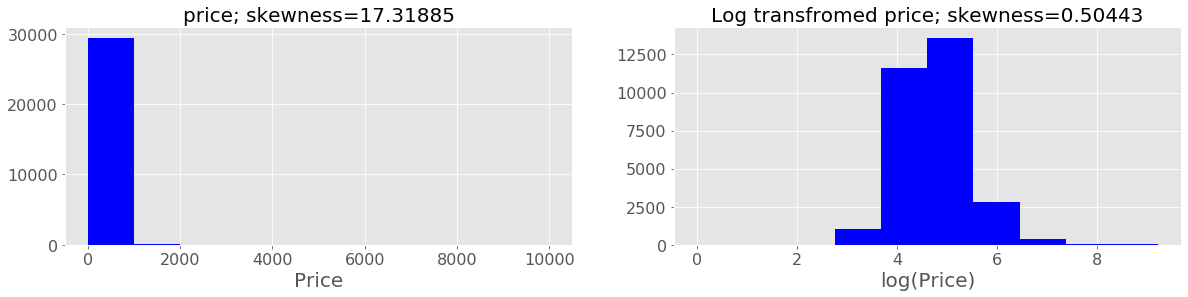

In [44]:
plot_price(train)

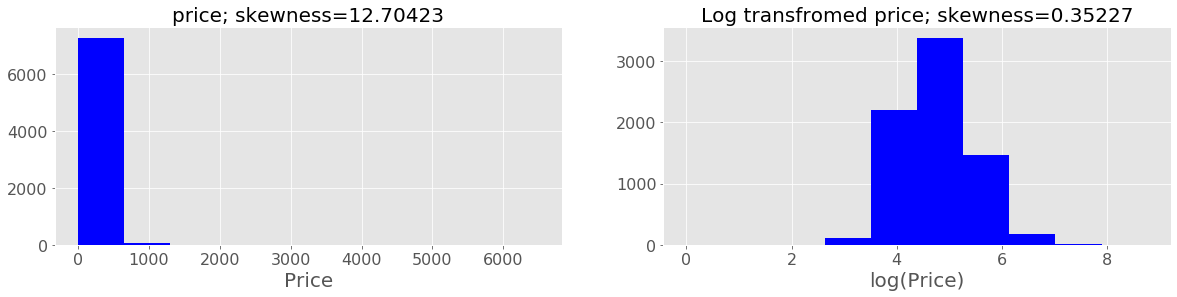

In [45]:
plot_price(test)

- Judging from the plots is obvious that some of the prices are quite extreme. Let us look at the summary of the quantitative properties of the price feature:

In [46]:
train['price'].describe()

count    29603.000000
mean       153.254501
std        228.020375
min          0.000000
25%         69.000000
50%        110.000000
75%        180.000000
max       9999.000000
Name: price, dtype: float64

- We observe some extreme values from the summary above as evidenced by the graph above. 
- Let us plot the graph again but with prices which exceeding \\$1000 excluded.

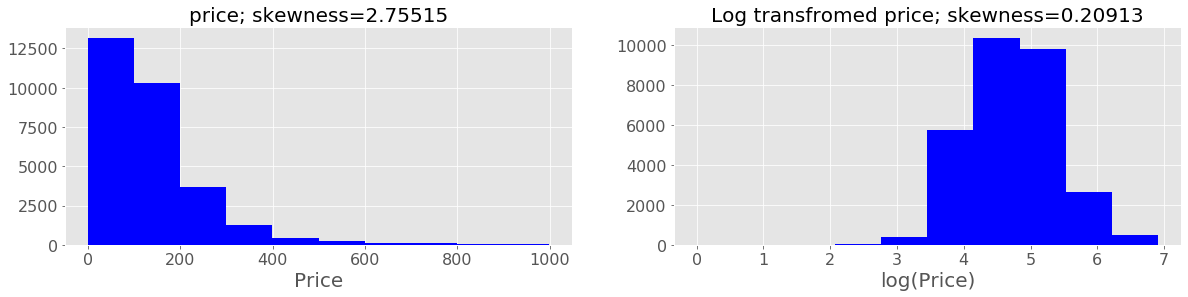

In [47]:
plot_price(train[train['price']<1000])

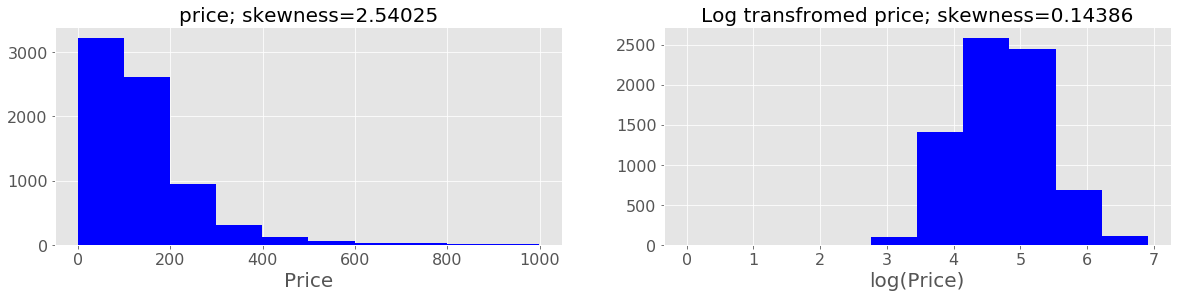

In [48]:
plot_price(test[test['price']<1000])

- It is obvious from the plot that a tiny fraction of the prices are above \\$1000. Let us compute the actual fraction.

In [49]:
print('Training set: percentage of prices exceeding $1000 is {:0.4f}%'
      .format(train[train['price']>1000].count()[0]/train.shape[0]),'\n')

print('Test set: percentage of prices exceeding $1000 is {:0.4f}%'
      .format(test[test['price']>1000].count()[0]/test.shape[0]))

Training set: percentage of prices exceeding $1000 is 0.0043% 

Test set: percentage of prices exceeding $1000 is 0.0035%


- We will treat prices exceeding $1000 as outliers; we will also remove zero prices.

In [50]:
def remove_outliers(df,feature,low_value,high_value):
    df = df[df[feature]>low_value]
    df = df[df[feature]<=high_value]
    df.reset_index(drop=True,inplace=True)
    return df

In [51]:
train=remove_outliers(train,'price',0,1000)

In [52]:
train.shape

(29469, 51)

In [53]:
test=remove_outliers(test,'price',0,1000)

In [54]:
test.shape

(7344, 51)

## 3(b) Scatter plots of price versus numerical features

- Let us examine the scatter plot of price versus each numerical feature.

- Again, we will also take particular notice of outliers in the numerical features and remove them where necessary.

In [55]:
def features_plot(feat,df):
    plt.rcParams['figure.figsize']=(15,15)
    plt.style.use(style='ggplot')
    xxx,sub=plt.subplots(5,6)
    xxx.subplots_adjust(hspace=0.5)
    sub=sub.flatten()
    for i in range(len(feat)):
        sub[i].scatter(x=df[feat[i]], y=np.log1p(df["price"]),s=4)
        sub[i].set_title('{}'.format(feat[i],fontsize=10))
#        sub[i].set_ylabel('log(SalePrice)',fontsize=20)
        sub[i].tick_params(labelsize=10)
    plt.show()


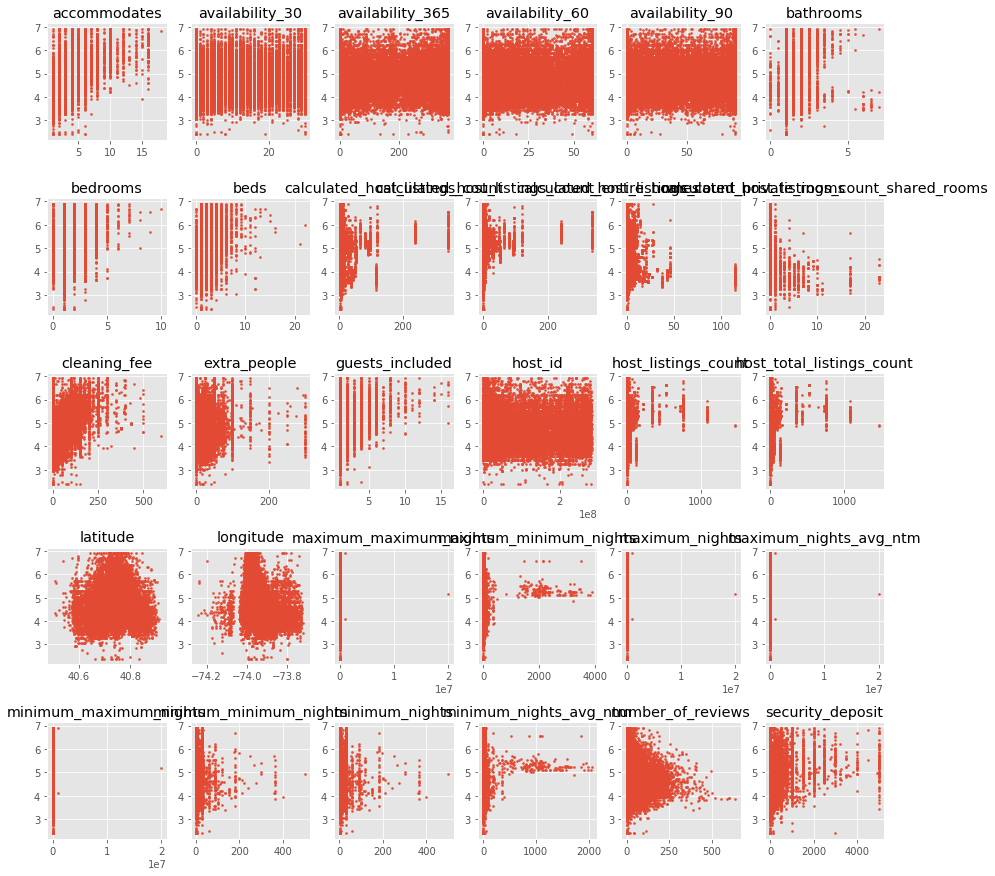

In [56]:
numerical_features = list(train.columns[train.dtypes != 'object'])
numerical_features.remove('price')
features_plot(sorted(numerical_features),train)

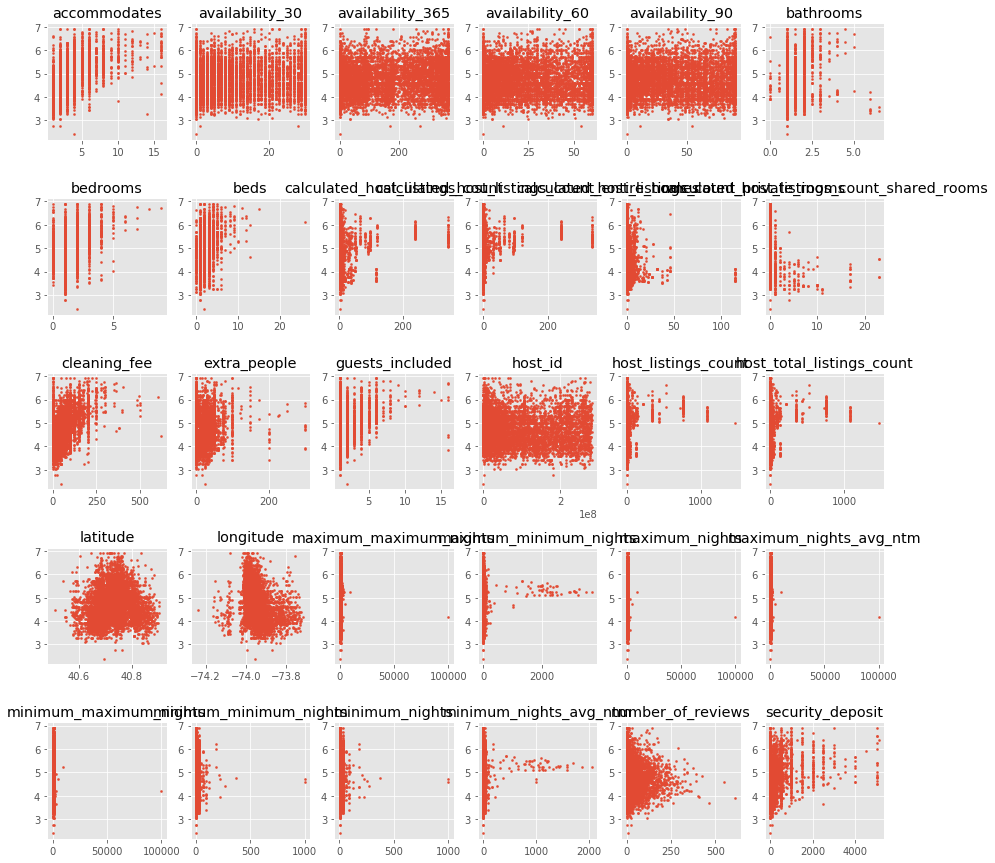

In [57]:
numerical_features = list(test.columns[test.dtypes != 'object'])
numerical_features.remove('price')
features_plot(sorted(numerical_features),test)

### Removing outliers from maximum_nights and minimum_nights

- It is obvious that maximum_nights and minimum_nights has outliers. 

- Let us replot the graphs for maximum_nights and minimum_nights with some realistic restrictions: we will restrict maximum nights to no more than 1200 and minimum nights to no more than 500. 

In [58]:
def outliers(df,cut_off_max,cut_off_min,title):
    df3=df[df['maximum_nights']<cut_off_max]
    df2=df
    plt.rcParams['figure.figsize']=(20,4)
    plt.style.use(style='ggplot')
    xxx,sub=plt.subplots(1,2)
    xxx.subplots_adjust(hspace=1)

    sub[0].scatter(x=df2['maximum_nights'], y=np.log1p(df2["price"]), color='blue')
    sub[0].set_xlabel('maximum_nights',fontsize=25)
    sub[0].set_title('With outliers',fontsize=25)
    sub[0].set_ylabel('log(price)',fontsize=25)
    sub[0].tick_params(labelsize=25)

    sub[1].scatter(x=df3['maximum_nights'], y=np.log1p(df3["price"]), color='blue')
    sub[1].set_xlabel('maximum_nights',fontsize=25)
    sub[1].set_title(title,fontsize=25)
    sub[1].set_ylabel('log(price)',fontsize=25)
    sub[1].tick_params(labelsize=25)
    plt.show()

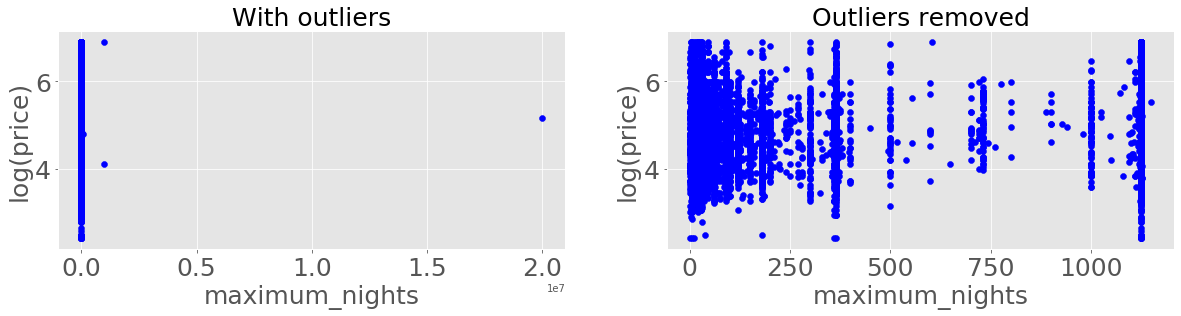

In [59]:
outliers(train,1200,500,'Outliers removed')

In [60]:
def plot_max_and_min_nights(df,cut_off_max,cut_off_min,title):
    df2=df[df['maximum_nights']<cut_off_max]
    df3=df[df['minimum_nights']<cut_off_min]
    plt.rcParams['figure.figsize']=(20,4)
    plt.style.use(style='ggplot')
    xxx,sub=plt.subplots(1,2)
    xxx.subplots_adjust(hspace=1)

    sub[0].scatter(x=df2['maximum_nights'], y=np.log1p(df2["price"]), color='red')
    sub[0].set_xlabel('maximum_nights',fontsize=25)
    sub[0].set_title(title,fontsize=25)
    sub[0].set_ylabel('log(price)',fontsize=25)
    sub[0].tick_params(labelsize=25)

    sub[1].scatter(x=df3['minimum_nights'], y=np.log1p(df3["price"]), color='blue')
    sub[1].set_xlabel('minimum_nights',fontsize=25)
    sub[1].set_title(title,fontsize=25)
    sub[1].set_ylabel('log(price)',fontsize=25)
    sub[1].tick_params(labelsize=25)
    plt.show()

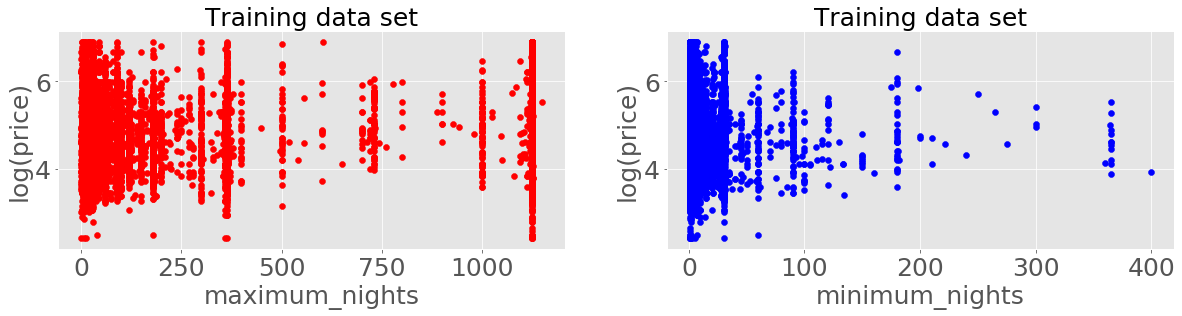

In [61]:
plot_max_and_min_nights(train,1200,500,'Training data set')

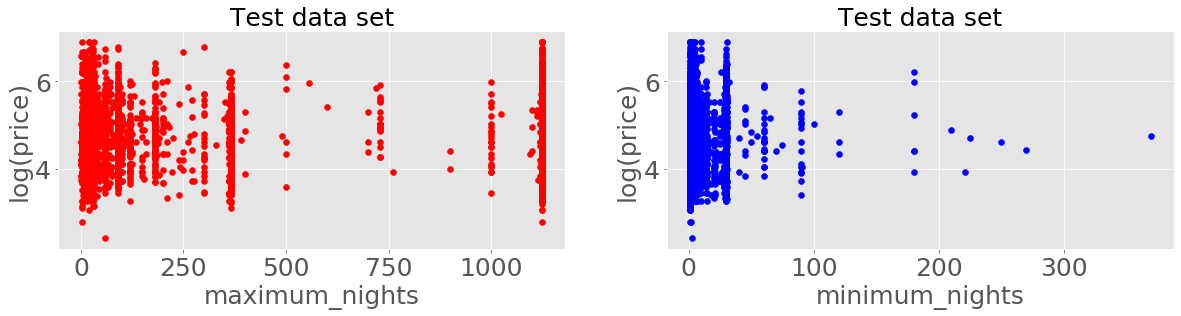

In [62]:
plot_max_and_min_nights(test,1200,500,'Test data set')

- We will go ahead and discard maximum_nights exceeding 1000 and minimum_nights exceeding 500

In [63]:
train=remove_outliers(train,'maximum_nights',0,1200)
train=remove_outliers(train,'minimum_nights',0,500)
train.shape

(29454, 51)

In [64]:
test=remove_outliers(test,'maximum_nights',0,1200)
test=remove_outliers(test,'minimum_nights',0,500)
test.shape

(7334, 51)

## 3(c) Average and median price of each property type

- There are 36 unique properties. We are interested in how frequently a given property is listed. We also interested in the average and median price per property.

In [65]:
def plot_property(df,title):
    all_properties=df['property_type'].tolist()
    fdist = FreqDist(all_properties)
    prop = pd.DataFrame({'Property': list(fdist.keys()),'Count': list(fdist.values())})
    prop = prop.nlargest(columns="Count", n = 10)
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize']=(20,6)
    plt.style.use(style='ggplot')
    prop.plot(x='Property',y='Count',kind='bar',color='red')
    plt.ylabel('Frequency',fontsize=25,color='blue')
    #plt.xlabel('Amenity',fontsize=25,color='blue')
    plt.title(title,fontsize=25,color='blue')
    #plt.xlabel('Amenity',fontsize=12)
    plt.tick_params(labelsize=20)
    plt.xticks(rotation='vertical')
    plt.legend(fontsize=22)
    plt.show()

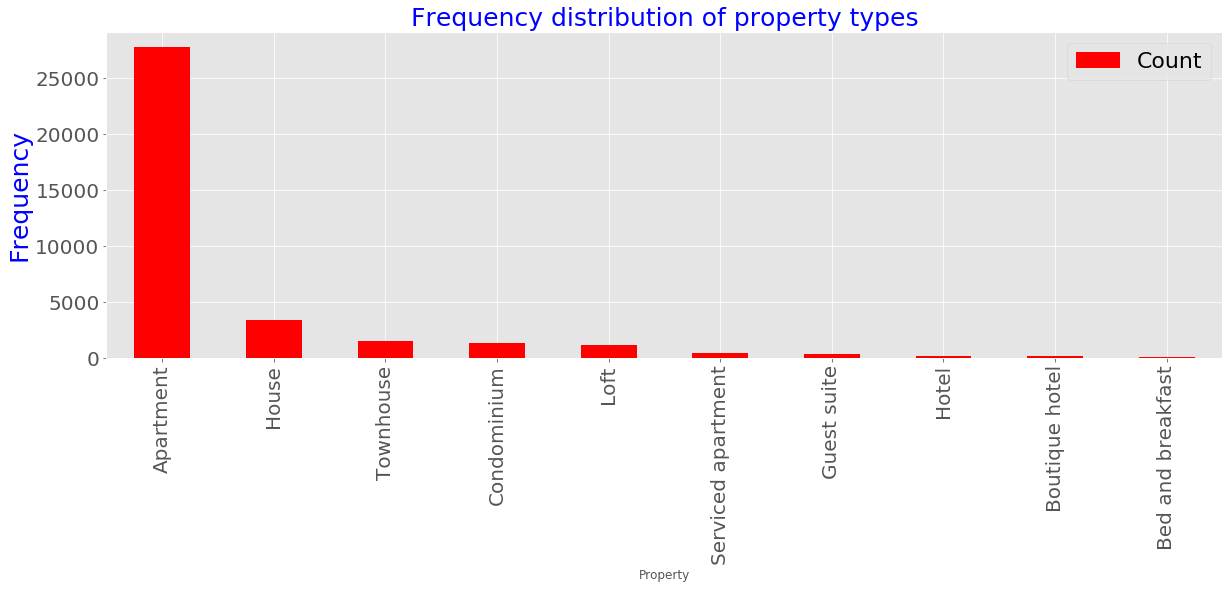

In [66]:
df = listings
title='Frequency distribution of property types'
plot_property(df,title)

In [67]:
#df = train
#title='Training set: Frequency distribution of property types'
#plot_property(df,title)

In [68]:
#df = test
#title='Test set: Frequency distribution of property types'
#plot_property(df,title)

In [69]:
def plot_average_price(feature,label,df,nlength,title,color1,color2):
    
    sort_price = df.groupby(feature)['price'].mean().sort_values(ascending=False)
    sort_price = sort_price.to_frame().reset_index()
    sort_price.rename(columns ={feature:label,
                           'price':'average price'}, inplace=True)
    
    d = sort_price.copy()
    d = d.nlargest(columns="average price", n =min(len(d),nlength))
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize']=(20,6)
    #plt.bar(d['neighbourhood'],d['average price'])
    d.plot(x=label, y='average price', kind="bar",color=color1)
    #plt.xlabel(label,fontsize=25,color=color2)
    plt.ylabel('Average price',fontsize=25,color=color2)
    plt.title(title,fontsize=25,color=color2)
    plt.tick_params(labelsize=22)
    plt.legend(fontsize=20)
    plt.xticks(rotation='vertical')
    plt.show()

def plot_median_price(feature,label,df,nlength,title,color1,color2):
    
    sort_price = df.groupby(feature)['price'].median().sort_values(ascending=False)
    sort_price = sort_price.to_frame().reset_index()
    sort_price.rename(columns ={feature:label,
                           'price':'median price'}, inplace=True)
    
    d = sort_price.copy()
    d = d.nlargest(columns="median price", n =min(len(d),nlength))
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize']=(20,6)
    #plt.bar(d['neighbourhood'],d['average price'])
    d.plot(x=label, y='median price', kind="bar",color=color1)
    #plt.xlabel(label,fontsize=25)
    plt.ylabel('Median price',fontsize=25,color=color2)
    plt.title(title,fontsize=25,color=color2)
    #plt.xlabel('Amenity',fontsize=12)
    plt.legend(fontsize=20)
    plt.tick_params(labelsize=22)
    plt.xticks(rotation='vertical')
    plt.show()


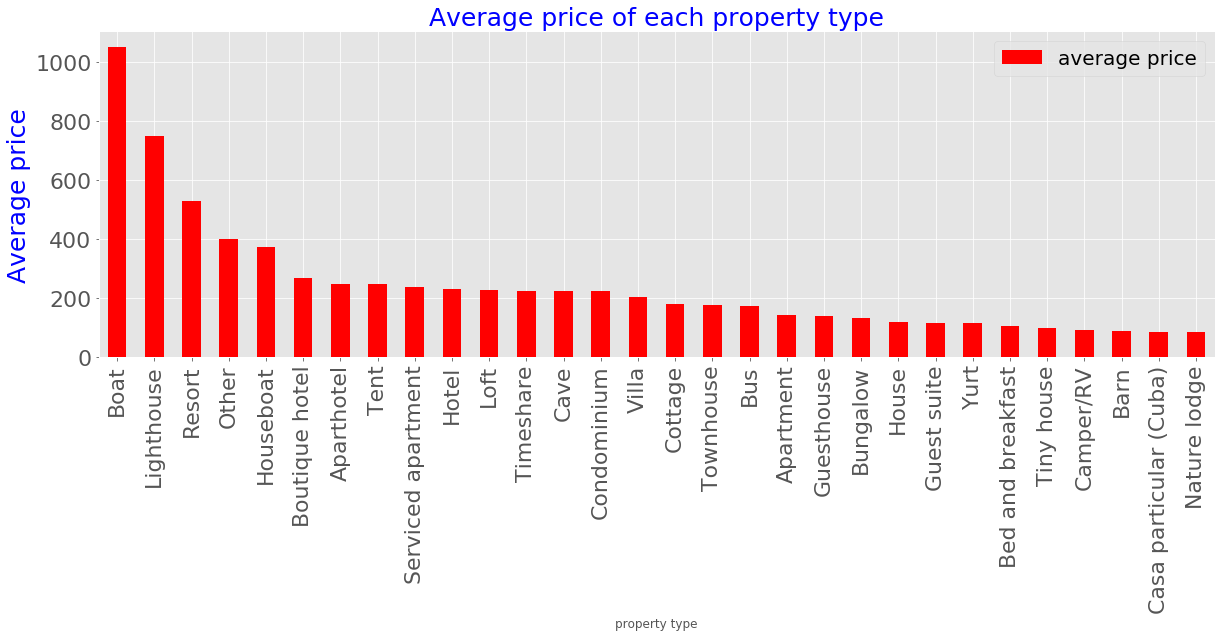

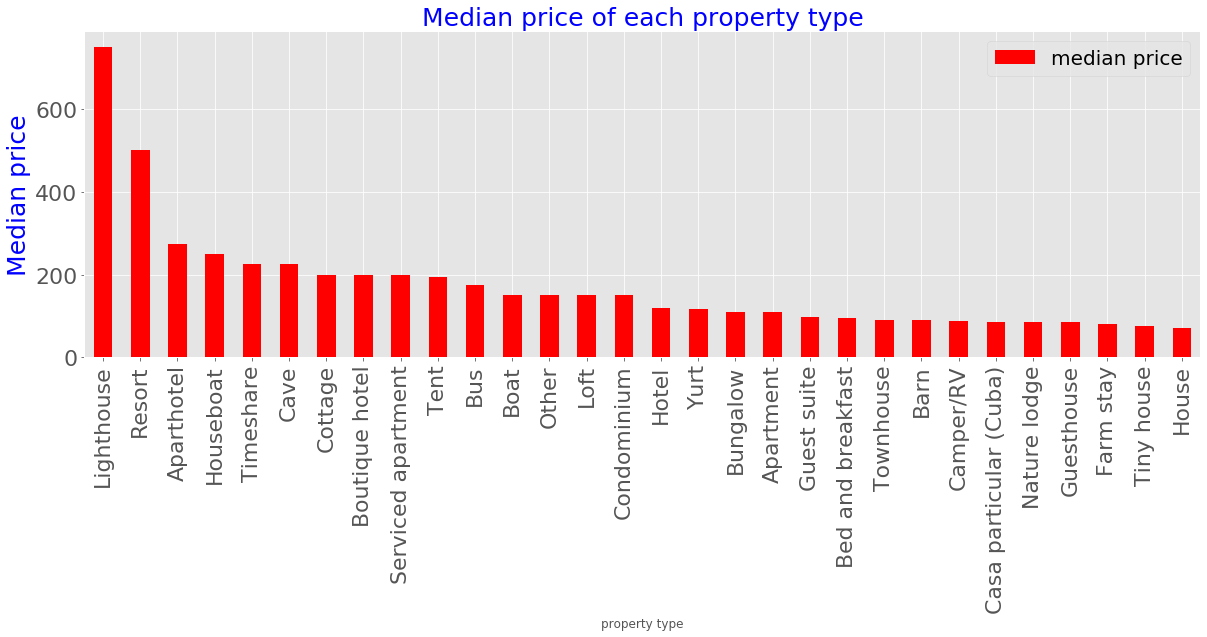

In [70]:
df=listings
title1 = 'Average price of each property type'
title2 = 'Median price of each property type'

plot_average_price('property_type','property type',df,30,title1,'red','blue')
plot_median_price('property_type','property type',df,30,title2,'red','blue')

In [71]:
#df=train
#title1 = 'Training set: Average price of each property type'
#title2 = 'Training set: Median price of each property type'

#plot_average_price('property_type','property type',df,30,title1,'red','blue')
#plot_median_price('property_type','property type',df,30,title2,'red','blue')

In [72]:
#df=test
#title1 = 'Test set: Average price of each property type'
#title2 = 'Test set: Median price of each property type'

#plot_average_price('property_type','property type',df,30,title1,'red','blue')
#plot_median_price('property_type','property type',df,30,title2,'red','blue')

## 3(d) Distribution of listings across neighborhoods

- How are the listings distributed over neighborhoods? 

- Let us look the distribution of the rental listings across relevant neighborhoods (i.e. zip codes with at least 300 listings)


In [73]:
def plot_neighboorhood(df,title,nthreshhold):
    print("Number of neighboorhoods in New York:", df.neighbourhood_cleansed.nunique(),'\n')
    listings_per_nbhood = df['neighbourhood_cleansed'].value_counts()

    acceptable_nbhood = listings_per_nbhood[listings_per_nbhood >=nthreshhold].index
    acceptable_listings = df[df['neighbourhood_cleansed'].isin(acceptable_nbhood)]
    listings_per_nbhood = acceptable_listings['neighbourhood_cleansed'].value_counts()
    #print("Number of neighboorhoods in New York with at least {} listings: {}".format(
    #nthreshhold,acceptable_listings['neighbourhood_cleansed'].nunique()))
    #print(acceptable_listings.shape)
    
    listings_per_nbhood.to_frame()
    listings_per_nbhood.columns = ['neighborhood','count']
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize']=(20,6)
    listings_per_nbhood.plot(x="neighborhood", y='count', kind="bar")
    #plt.xlabel('neighborhood',fontsize=25)
    plt.ylabel('Number of listings',fontsize=25,color='blue')
    plt.title(title,fontsize=25,color='blue')
    #plt.xlabel('Amenity',fontsize=12)
    plt.tick_params(labelsize=22)
    plt.legend(fontsize=22)
    plt.show()

Number of neighboorhoods in New York: 221 



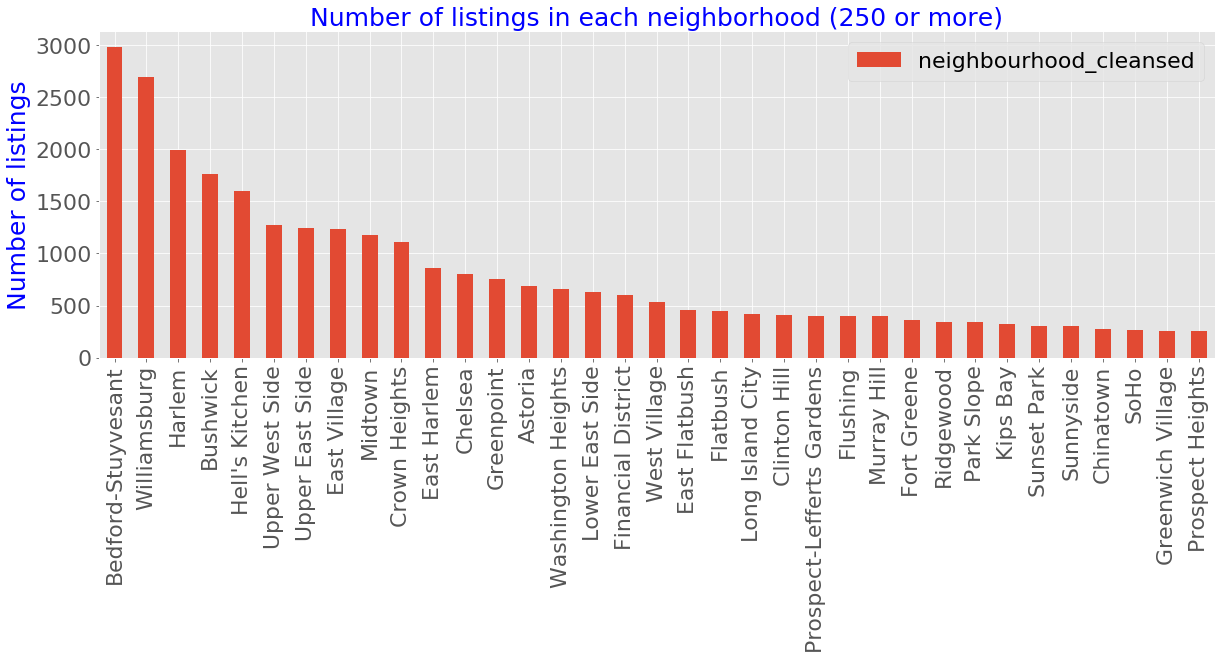

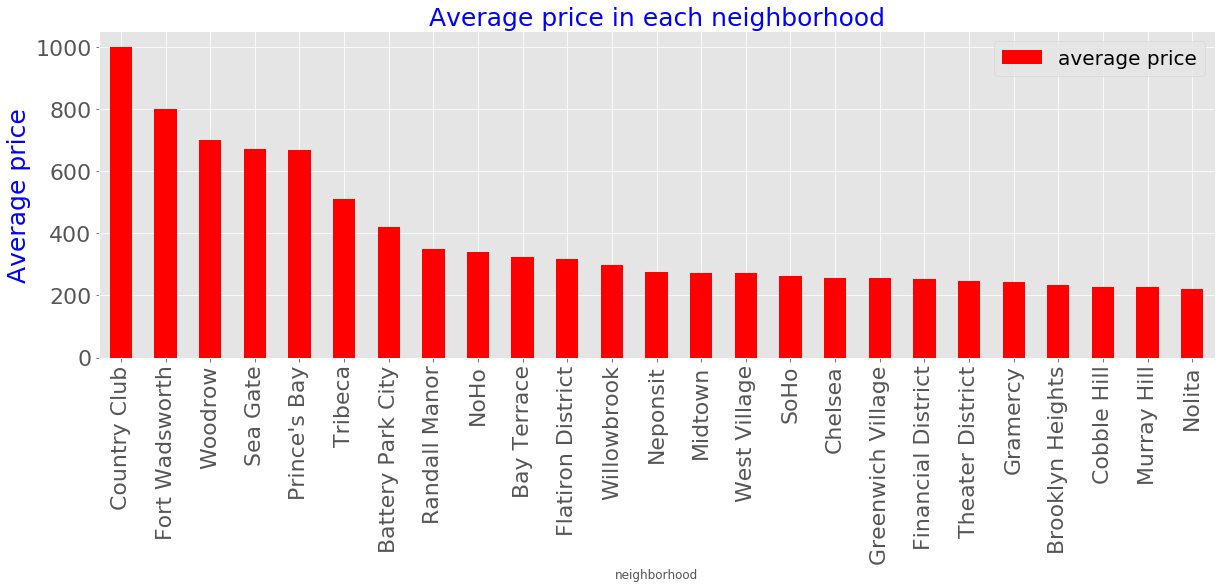

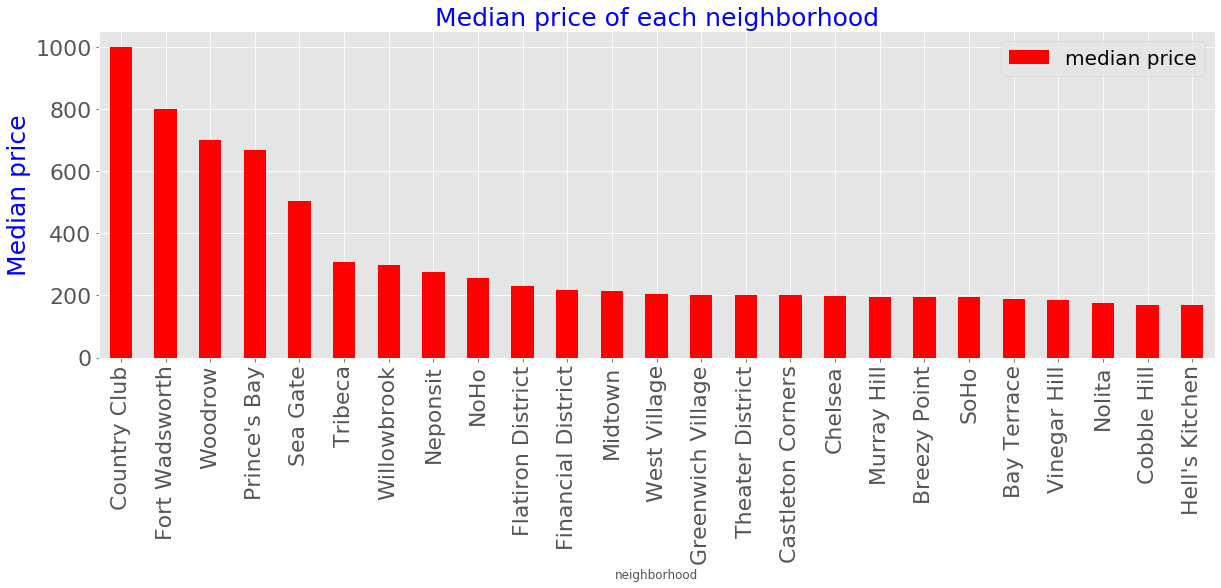

In [74]:
df = listings
nthreshhold=250
nshow=25

title1 = 'Number of listings in each neighborhood (250 or more)'
title2 = 'Average price in each neighborhood'
title3 = 'Median price of each neighborhood'

plot_neighboorhood(df,title1,nthreshhold)
plot_average_price('neighbourhood_cleansed','neighborhood',df,nshow,title2,'red','blue')
plot_median_price('neighbourhood_cleansed','neighborhood',df,nshow,title3,'red','blue')

In [75]:
#df = train
#nthreshhold=250
#nshow=25

#title1 = 'Training set: number of listings in each neighborhood (250 or more)'
#title2 = 'Training set: Average price in each neighborhood'
#title3 = 'Training set: Median price of each neighborhood'

#plot_neighboorhood(df,title1,nthreshhold)
#plot_average_price('neighbourhood_cleansed','neighborhood',df,nshow,title2,'red','blue')
#plot_median_price('neighbourhood_cleansed','neighborhood',df,nshow,title3,'red','blue')


In [76]:
#df = test
#nthreshhold=100
#nshow=25

#title1 = 'Test set: number of listings in each neighborhood (100 or more)'
#title2 = 'Test set: Average price in each neighborhood'
#title3 = 'Test set: Median price of each neighborhood'

#plot_neighboorhood(df,title1,nthreshhold)
#plot_average_price('neighbourhood_cleansed','neighborhood',df,nshow,title2,'red','blue')
#plot_median_price('neighbourhood_cleansed','neighborhood',df,nshow,title3,'red','blue')


### 3(e) Distribution  price with respect to room type?

 - How do the prices vary over various room types?
 

In [77]:
def plot_price_wrt_room_type(df,title):
    df2 = df.pivot(columns='room_type',values='price')
    x1=list(df2[df2.columns[0]])
    x2=list(df2[df2.columns[1]])
    x3=list(df2[df2.columns[2]])

    plt.rc('legend',**{'fontsize':25})
    #plt.legend(fontsize=20)
    plt.rcParams['figure.figsize']=(15,8)
    plt.style.use(style='ggplot')
    plt.tick_params(labelsize=25)
    plt.ylabel("Count",fontsize=25,color='blue')
    plt.xlabel("Price",fontsize=25,color='blue')
    plt.title(title,fontsize=25,color='blue')
    #plt.legend(prop={'size': 10}) 
    plt.tick_params(labelsize=25)
    n_bins=12
    colors = ['yellow', 'red', 'green']
    labels=[df2.columns[0],df2.columns[1],df2.columns[2]]
    plt.hist([x1, x2, x3], n_bins, histtype='bar', 
             color=colors, range=[0,400],label=labels,alpha=1)
         
    plt.legend(loc="upper right")
    plt.show()

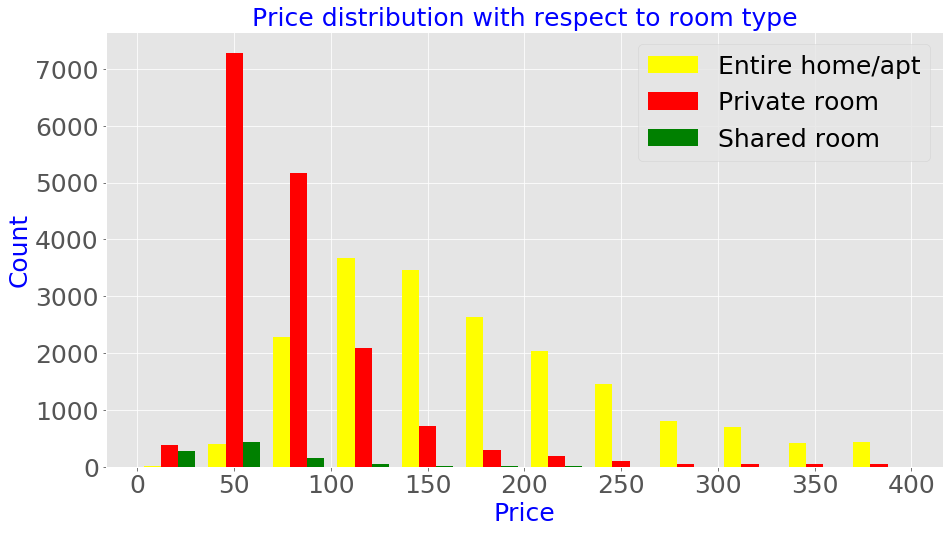

In [78]:
df=listings
title='Price distribution with respect to room type'
plot_price_wrt_room_type(df,title)

In [79]:
#df=train
#title='Training set: Price distribution with respect to room type'
#plot_price_wrt_room_type(df,title)

In [80]:
#df=test
#title='Test set: Price distribution with respect to room type'
#plot_price_wrt_room_type(df,title)

### 3(f) Distribution  price with respect to number of beds?

 - How do the prices vary with respect to the number of beds in a listing?
 

In [81]:
def plot_price_wrt_number_of_beds(df,title):
    df2 = df.pivot(columns='beds',values='price')
    x=[list(df2[df2.columns[i]]) for i in range(len(df2.columns)) if i <= 10]
    labels=[str(int(df2.columns[i]))+' beds' for i in range(len(df2.columns))]

    plt.rc('legend',**{'fontsize':20})
    plt.rcParams['figure.figsize']=(15,8)
    plt.style.use(style='ggplot')
    plt.tick_params(labelsize=14)
    plt.ylabel("Count",fontsize=25,color='blue')
    plt.xlabel("Price",fontsize=25,color='blue')
    plt.title(title,fontsize=25,color='blue')
    #plt.legend(prop={'size': 10}) 
    plt.tick_params(labelsize=25)
    n_bins=12
    plt.hist(x, n_bins, stacked=True,range=[0,600],label=labels)        
    plt.legend(loc="upper right")
    plt.show()

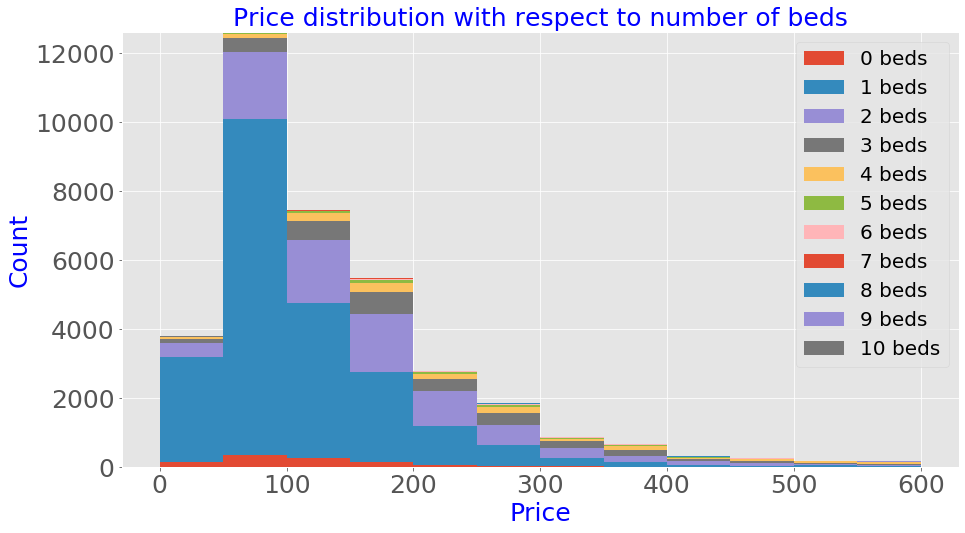

In [82]:
df=listings
title='Price distribution with respect to number of beds'
plot_price_wrt_number_of_beds(df,title)

In [83]:
#df=train
#title='Training set: Price distribution with respect to number of beds'
#plot_price_wrt_number_of_beds(df,title)

In [84]:
#df=test
#title='Test set: Price distribution with respect to number of beds'
#plot_price_wrt_number_of_beds(df,title)

## 3(g) Distribution of amenities 

- Every listing has a set of amenities, e.g. TV, air conditioning, etc; there 128 unique amenities. 

- We would like to know how frequent a given amenity is per listing. 

- First let's find out how many unique ameneties there are, and then we will plot the frequency distribution.

- We also interested in the distribution of the average and median price with respect to each amenity


In [85]:
def get_amenities(df,message1,message2):
    all_amenities=df['amenities'].tolist()
    #all_amenities=','.join(all_amenities).split(',')
    all_amenities=','.join(map(str, all_amenities)).split(',')
    #all_amenities=list(all_amenities)
    #x='\'\''
    #if x in all_amenities: print('Yes')
    unique_amenities=set(all_amenities)
    unique_amenities=list(unique_amenities)
    print()
    print(message1.format(len(unique_amenities)),'\n')
    print(message2.format(sorted(unique_amenities)))
    
    return (all_amenities,unique_amenities)


In [86]:
df = listings
message1='Number of unique amenities is {}'
message2='List of amenities={}'
all_amenities_listings,unique_amenities_listings = get_amenities(df,message1,message2)


Number of unique amenities is 128 

List of amenities=['24-hour check-in', 'Accessible-height bed', 'Accessible-heighttoilet', 'Air conditioning', 'Air purifier', 'BBQ grill', 'Baby bath', 'Baby monitor', 'Babysitter recommendations', 'Bathtub', 'Bathtub with bath chair', 'Beach essentials', 'Beachfront', 'Bed linens', 'Breakfast', 'Building staff', 'Buzzer/wireless intercom', 'Carbon monoxide detector', 'Cat(s)', 'Ceiling hoist', 'Changing table', 'Children’s books and toys', 'Children’s dinnerware', 'Cleaning before checkout', 'Coffee maker', 'Cooking basics', 'Crib', 'Disabled parking spot', 'Dishes and silverware', 'Dishwasher', 'Dog(s)', 'Doorman', 'Dryer', 'EV charger', 'Electric profiling bed', 'Elevator', 'Essentials', 'Ethernet connection', 'Extra pillows and blankets', 'Extra space around bed', 'Family/kid friendly', 'Fire extinguisher', 'Fireplace guards', 'Firm mattress', 'First aid kit', 'Fixed grab bars for shower', 'Fixed grab bars fortoilet', 'Flat path to guest entran

In [87]:
df = train
message1='Training set: number of unique amenities is {}'
message2='Training set: list of amenities={}'
all_amenities_train,unique_amenities_train = get_amenities(df,message1,message2)


Training set: number of unique amenities is 128 

Training set: list of amenities=['24-hour check-in', 'Accessible-height bed', 'Accessible-heighttoilet', 'Air conditioning', 'Air purifier', 'BBQ grill', 'Baby bath', 'Baby monitor', 'Babysitter recommendations', 'Bathtub', 'Bathtub with bath chair', 'Beach essentials', 'Beachfront', 'Bed linens', 'Breakfast', 'Building staff', 'Buzzer/wireless intercom', 'Carbon monoxide detector', 'Cat(s)', 'Ceiling hoist', 'Changing table', 'Children’s books and toys', 'Children’s dinnerware', 'Cleaning before checkout', 'Coffee maker', 'Cooking basics', 'Crib', 'Disabled parking spot', 'Dishes and silverware', 'Dishwasher', 'Dog(s)', 'Doorman', 'Dryer', 'EV charger', 'Electric profiling bed', 'Elevator', 'Essentials', 'Ethernet connection', 'Extra pillows and blankets', 'Extra space around bed', 'Family/kid friendly', 'Fire extinguisher', 'Fireplace guards', 'Firm mattress', 'First aid kit', 'Fixed grab bars for shower', 'Fixed grab bars fortoilet'

In [88]:
df = test
message1='Test set: number of unique amenities is {}'
message2='Test set: list of amenities={}'
all_amenities_test,unique_amenities_test = get_amenities(df,message1,message2)


Test set: number of unique amenities is 127 

Test set: list of amenities=['24-hour check-in', 'Accessible-height bed', 'Accessible-heighttoilet', 'Air conditioning', 'Air purifier', 'BBQ grill', 'Baby bath', 'Baby monitor', 'Babysitter recommendations', 'Bathtub', 'Bathtub with bath chair', 'Beach essentials', 'Beachfront', 'Bed linens', 'Breakfast', 'Building staff', 'Buzzer/wireless intercom', 'Carbon monoxide detector', 'Cat(s)', 'Ceiling hoist', 'Changing table', 'Children’s books and toys', 'Children’s dinnerware', 'Cleaning before checkout', 'Coffee maker', 'Cooking basics', 'Crib', 'Disabled parking spot', 'Dishes and silverware', 'Dishwasher', 'Dog(s)', 'Doorman', 'Dryer', 'EV charger', 'Electric profiling bed', 'Elevator', 'Essentials', 'Ethernet connection', 'Extra pillows and blankets', 'Extra space around bed', 'Family/kid friendly', 'Fire extinguisher', 'Fireplace guards', 'Firm mattress', 'First aid kit', 'Fixed grab bars for shower', 'Fixed grab bars fortoilet', 'Flat 

In [89]:
def amenities_frequency_plot(amenities,title,plot):
    
    fdist = FreqDist(amenities)
    d = pd.DataFrame({'Amenity': list(fdist.keys()),'Count': list(fdist.values())})
    #print(d.shape) 
    d2=d.copy()
    d2 = d2.nlargest(columns="Count", n = 25)

    if plot==True:
        plt.style.use('ggplot')
        plt.rcParams['figure.figsize']=(20,6)
        plt.style.use(style='ggplot')
        d2.plot(x='Amenity',y='Count',kind='bar',color='red')
        plt.ylabel('Frequency',fontsize=25,color='blue')
        #plt.xlabel('Amenity',fontsize=25,color='blue')
        plt.title(title,fontsize=25,color='blue')
        #plt.xlabel('Amenity',fontsize=12)
        plt.tick_params(labelsize=20)
        plt.xticks(rotation='vertical')
        plt.show()
    
    return d

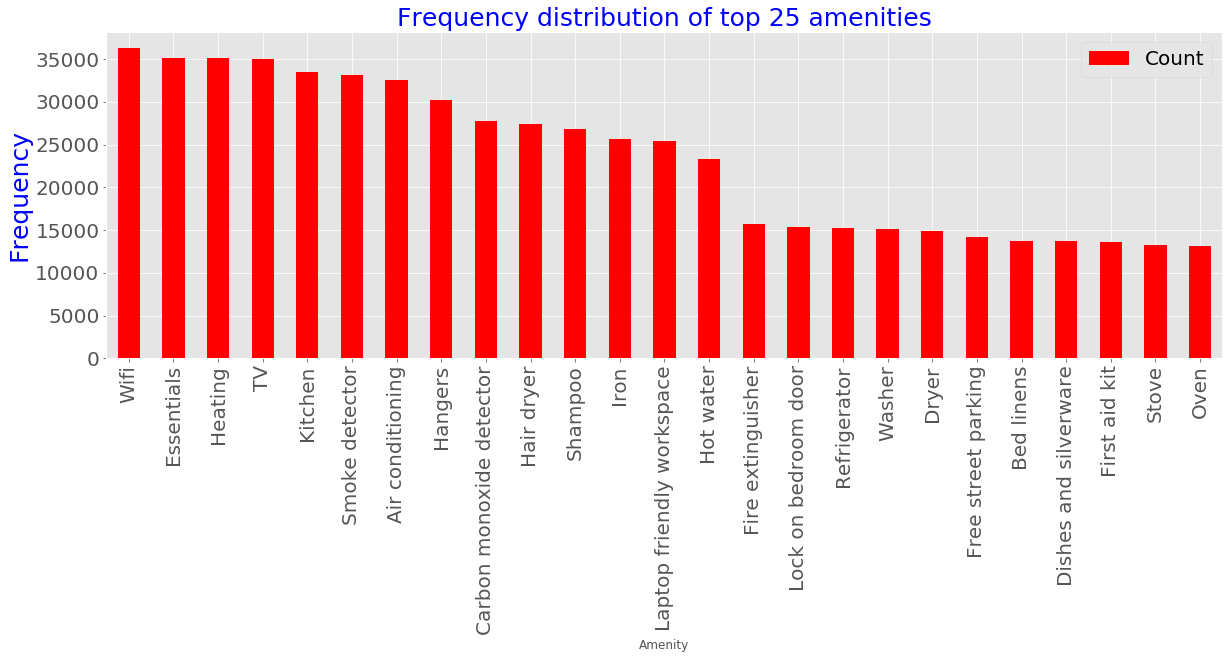

In [90]:
amenities=all_amenities_listings
title='Frequency distribution of top 25 amenities'
amenities_freq_dist_train=amenities_frequency_plot(amenities,title,True)

In [91]:
amenities=all_amenities_train
title='Training set: Frequency distribution of top 25 amenities'
amenities_freq_dist_train=amenities_frequency_plot(amenities,title,False)

In [92]:
amenities=all_amenities_test
title='Test set: Frequency distribution of top 25 amenities'
amenities_freq_dist_test=amenities_frequency_plot(amenities,title,False)

In [93]:
def plot_avg_median_price_amenity(df,unique_amenities,title,measure,ylabel):
    if measure=='mean':
        amenity_prices = [
            (amn, df[df['amenities'].map(lambda amns: amn in amns)]['price'].mean()) 
            for amn in unique_amenities
        ]
    elif measure=='median': 
        amenity_prices = [
            (amn, df[df['amenities'].map(lambda amns: amn in amns)]['price'].median()) 
            for amn in unique_amenities
        ]
    else:
        return 'measure not found'
        

    amenity_vs_price = pd.Series(data=[a[1] for a in amenity_prices], 
                                 index=[a[0] for a in amenity_prices])
    amenity_vs_price = amenity_vs_price.to_frame().reset_index()
    
    amenity_vs_price = amenity_vs_price.rename(
        columns= {0: ylabel,'index': 'amenity'})

    d2 = amenity_vs_price.nlargest(columns=ylabel, n = 25)
    d2.head()

    plt.style.use('ggplot')
    plt.rcParams['figure.figsize']=(20,6)
    plt.style.use(style='ggplot')
    #plt.bar(d['amenity'],d['average price'],color='blue')
    d2.plot(x='amenity',y=ylabel,kind='bar',color='red')
    plt.ylabel(ylabel,fontsize=25,color='blue')
    plt.title(title,fontsize=25,color='blue')
    #plt.xlabel('Amenity',fontsize=12)
    plt.tick_params(labelsize=22)
    plt.xticks(rotation='vertical')

    plt.show()

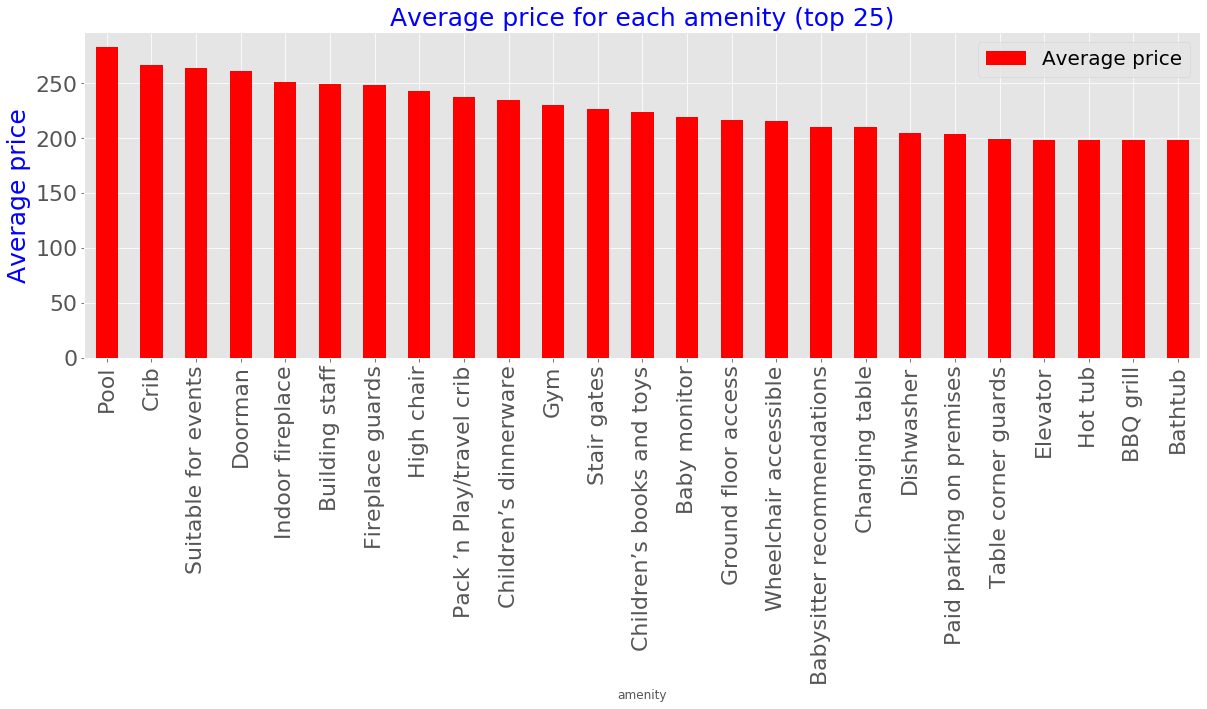

In [94]:
df =listings
unique_amenities = unique_amenities_listings

title='Average price for each amenity (top 25)'
measure='mean'
ylabel='Average price'
plot_avg_median_price_amenity(df,unique_amenities,title,measure,ylabel)

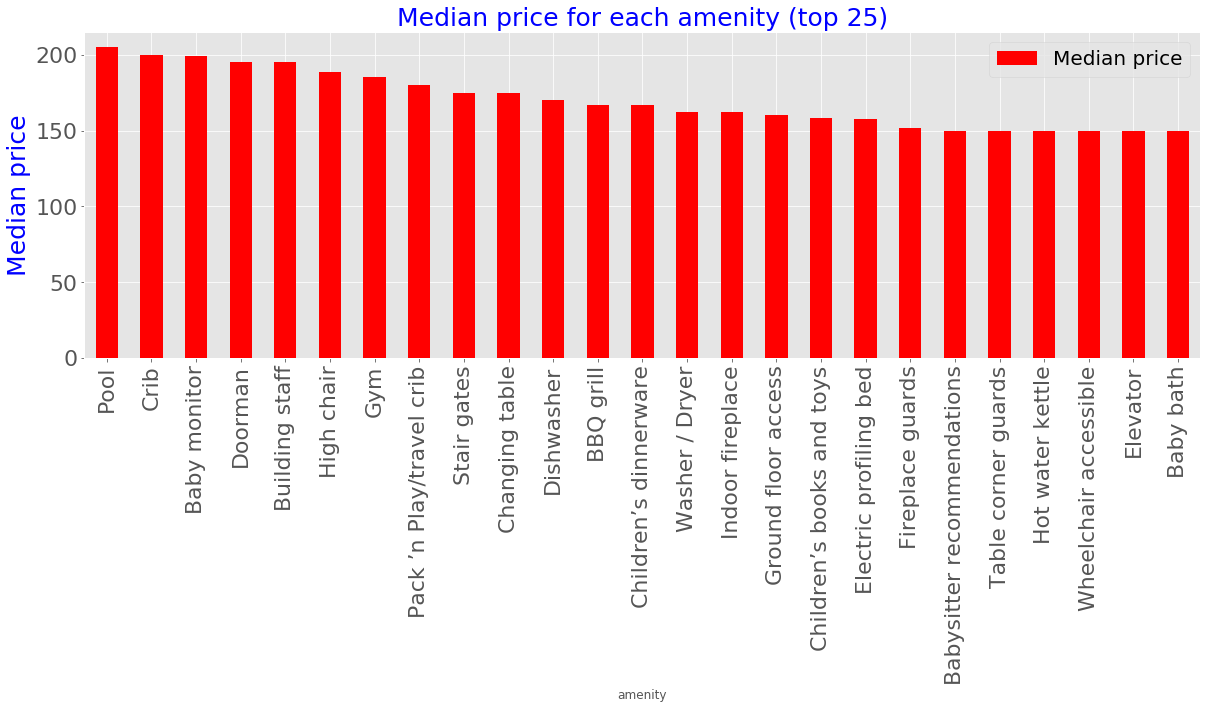

In [95]:
df =listings
unique_amenities = unique_amenities_listings

title='Median price for each amenity (top 25)'
measure='median'
ylabel='Median price'
plot_avg_median_price_amenity(df,unique_amenities,title,measure,ylabel)

In [96]:
#df =train
#unique_amenities = unique_amenities_train

#title='Training set: Average price for each amenity (top 25)'
#measure='mean'
#ylabel='Average price'
#plot_avg_median_price_amenity(df,unique_amenities,title,measure,ylabel)

#title='Training set: Median price for each amenity (top 25)'
#measure='median'
#ylabel='Median price'
#plot_avg_median_price_amenity(df,unique_amenities,title,measure,ylabel)

In [97]:
#df =test
#unique_amenities = unique_amenities_test

#title='Test set: Average price for each amenity (top 25)'
#measure='mean'
#ylabel='Average price'
#plot_avg_median_price_amenity(df,unique_amenities,title,measure,ylabel)

#title='Test set: Median price for each amenity (top 25)'
#measure='median'
#ylabel='Median price'
#plot_avg_median_price_amenity(df,unique_amenities,title,measure,ylabel)

# 4. Feature engineering


## 4(a) Engineering the amenities features 

There are numerous amenities per listing (a listing easy has 20 to 40 amenities). Using the frequency distribution for the amenities (see the first figure in section **3(g)** above), we decided to assign each amenity a weight based on it's frequency across all the listings considered: $$w(i) = \frac{f(i)}{f_{max}},$$

where $f(i)$ is the frequency of amenity $i$ and $f_{max}={\rm max}\{f(i):\, i\in {\rm amenities}\}$ is the maximum 
frequency ($f_{max}$ is due to the WiFi amenity). In essence, the  more frequent an specific amenity, the greater its weight (the maximum value of $w(i)$ is is 1; the minimum value is 0). For example, WiFi, Essentials and TV are the 3 most frequently listed amenities and accordingly, the possess weights of 1, 0.957 and 0.948 respectively.

For a listing containing $N$ amenities, we decided to replace the set of amenities by the sum $s$ of the weights of the amenities: $$s=\sum_{i=1}^{N}w(i).$$

### <font color=red> This feature engineering calculation below take while so be patient</font>

In [98]:
def apply_weights_to_listings(x,w):
    x = list(x.split(','))
    s=sum([w['Count'][w['Amenity'][w['Amenity']==i].index.tolist()[0]] for i in x])
    return s

def engineer_amenities(df,amenities_freq_dist):
    w = amenities_freq_dist.copy()
    w['Count'] = w['Count']/w['Count'].max()
    df['amenities']=df['amenities'].apply(apply_weights_to_listings,args=[w])
    return df

In [99]:
train_backup = train.copy()
train = engineer_amenities(train,amenities_freq_dist_train)

In [100]:
train.shape

(29454, 51)

In [101]:
train['amenities'].head()

0    13.464043
1    10.242527
2    10.817777
3    17.599993
4     7.089850
Name: amenities, dtype: float64

In [102]:
test_backup = test.copy()
test = engineer_amenities(test,amenities_freq_dist_test)

In [103]:
test.shape

(7334, 51)

In [104]:
test['amenities'].head()

0    16.623614
1    16.865992
2    18.102550
3     6.376386
4    19.616547
Name: amenities, dtype: float64

## 4(b) Label encode categorical variables

In [105]:
def encode(df):
    categorical_features = list(df.columns[df.dtypes == 'object'])
    for i in  categorical_features:
        df[i] = LabelEncoder().fit_transform(df[i])
    return df

In [106]:
train = encode(train)

In [107]:
train.head()

,host_id,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,state,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,13649613,0,8.0,8.0,306,1,1,200,0,2,63,40.85535,-73.91388,0,22,1,2,1.0,1.0,1.0,4,13.464043,57.0,0.0,10.0,1,0.0,2,25,2,5,14,25,2.1,24.9,0,6,15,18,18,0,107,0,0,3,0,0,4,0,4,0
1,267744284,0,1.0,1.0,425,1,0,125,0,2,61,40.82231,-73.91696,1,1,0,4,1.0,1.0,1.0,4,10.242527,69.0,0.0,0.0,2,10.0,7,25,7,7,25,25,7.0,25.0,0,10,14,18,282,0,0,1,0,3,0,0,1,1,0,0
2,519554,0,5.0,5.0,276,1,1,120,2,2,4,40.72007,-73.98775,1,1,1,2,1.0,1.0,1.0,4,10.817777,59.0,0.0,20.0,1,20.0,3,6,3,3,6,6,3.0,6.0,0,20,40,67,333,0,37,0,0,3,0,0,5,0,5,0
3,5776966,1,1.0,1.0,306,1,1,87,2,2,11,40.73683,-73.98191,1,1,1,1,1.0,1.0,1.0,4,17.599993,65.0,600.0,80.0,1,0.0,3,1125,3,3,1125,1125,3.0,1125.0,0,0,5,15,15,1,22,0,0,1,0,0,1,0,1,0
4,7340654,1,1.0,1.0,334,1,0,214,1,2,106,40.71174,-73.94767,1,1,1,2,1.0,1.0,1.0,4,7.089850,45.0,0.0,15.0,1,10.0,1,31,1,1,31,31,1.0,31.0,0,0,0,0,0,0,7,1,0,1,0,0,1,0,1,0


In [108]:
test = encode(test)

In [109]:
test.head()

,host_id,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,state,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,7549,1,4.0,4.0,170,1,1,32,2,1,2,40.71344,-73.99037,1,1,0,3,1.0,1.0,2.0,4,16.623614,150.0,0.0,40.0,2,10.0,1,1125,1,1,1125,1125,1.0,1125.0,0,0,0,0,0,0,161,0,0,3,0,0,4,2,0,2
1,15991,0,1.0,1.0,221,1,0,192,1,1,101,40.70837,-73.95352,1,1,0,3,1.0,1.0,1.0,4,16.865992,140.0,200.0,90.0,2,20.0,2,90,2,2,90,90,2.0,90.0,0,5,7,12,23,0,154,0,0,3,0,0,1,1,0,0
2,17571,1,1.0,1.0,217,1,1,75,1,1,95,40.69169,-73.97185,1,1,0,4,1.0,1.0,2.0,4,18.102550,215.0,200.0,0.0,2,30.0,2,30,2,2,30,30,2.0,30.0,0,14,27,35,305,0,200,1,0,0,0,0,1,1,0,0
3,17985,0,2.0,2.0,187,1,1,57,2,1,26,40.79685,-73.94872,1,1,0,4,1.0,2.0,2.0,4,6.376386,190.0,0.0,0.0,1,0.0,7,365,7,7,365,365,7.0,365.0,0,11,11,11,275,0,0,0,0,0,0,0,2,1,1,0
4,22486,0,5.0,5.0,79,1,1,137,1,1,107,40.68069,-73.97706,1,2,1,4,3.5,1.0,2.0,4,19.616547,115.0,0.0,15.0,2,30.0,2,120,2,2,120,120,2.0,120.0,0,11,41,66,117,0,131,0,0,1,0,1,4,0,4,0


## 4(c) Examine the correlation between the features in training data set

In [110]:
corrmat = train.corr()
print (corrmat['price'].sort_values(ascending=False)[:15], '\n')
print (corrmat['price'].sort_values(ascending=False)[-10:])

price                                          1.000000
accommodates                                   0.542980
cleaning_fee                                   0.470396
bedrooms                                       0.417144
beds                                           0.412047
guests_included                                0.343912
bathrooms                                      0.274626
security_deposit                               0.220856
amenities                                      0.190371
calculated_host_listings_count_entire_homes    0.173477
host_total_listings_count                      0.157694
host_listings_count                            0.157694
calculated_host_listings_count                 0.145303
neighbourhood_cleansed                         0.122831
availability_30                                0.120870
Name: price, dtype: float64 

is_location_exact                              -0.007570
host_identity_verified                         -0.008353
number_of_review

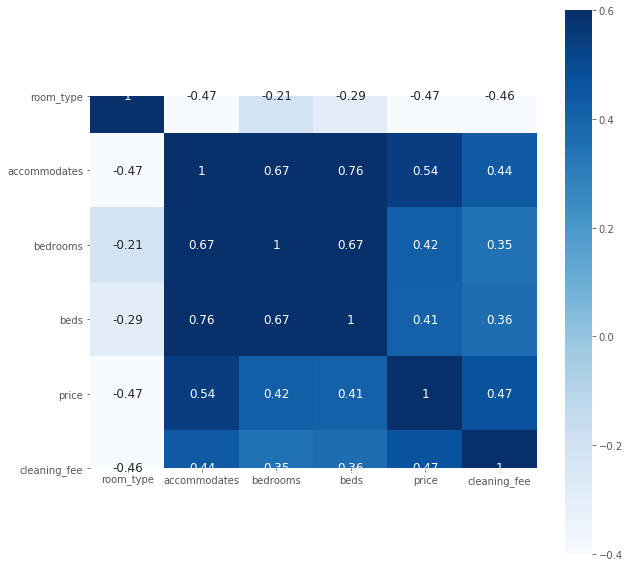

In [111]:
top_corr_features = corrmat.index[abs(corrmat["price"])>0.4]
plt.figure(figsize=(10,10))
sns.heatmap(train[top_corr_features].corr(), annot = True, cmap = "Blues", 
                cbar = True, vmin = -0.4, vmax = 0.6, square=True, annot_kws={"size": 12})
#sns.heatmap(corrmat,annot= True)

In [112]:
#df=train.copy()
#numerical_features = df.columns[df.dtypes != 'object']
#skew_features = [i for i in numerical_features]
#skew_features.remove('price')

#skew_features

#skew_features = [i for i in df[skew_features].columns if df[i].skew() > .7]

#for i in skew_features:
#    df[i]=boxcox1p(df[i], boxcox_normmax(df[i]+1))
   

In [113]:
#corrmat = df.corr()
#print (corrmat['price'].sort_values(ascending=False)[:15], '\n')
#print (corrmat['price'].sort_values(ascending=False)[-10:])

# 5. Machine Learning

## 5(a) Split the data into a test set and a training set

In [137]:
#Back up copy
X_train=train.copy()
X_test=test.copy()
X_charlie = train.loc[train['host_id'] == 17604711].copy()


y_train = np.log1p(X_train['price'])
y_test  = np.log1p(X_test['price'])
y_charlie = np.log1p(X_charlie['price'])

#drop_features=['price',jurisdiction_names','license','square_feet','has_availability']
drop_features=['price']
X_train.drop(drop_features,axis=1,inplace = True)
X_test.drop(drop_features,axis=1,inplace = True)
X_charlie.drop(drop_features,axis=1,inplace = True)

In [138]:
X_charlie.head()

,host_id,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,state,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
14521,17604711,0,1.0,1.0,326,1,0,58,1,2,97,40.6904,-73.98502,1,1,0,3,1.0,1.0,1.0,4,10.924664,150.0,75.0,2,20.0,8,1125,8,8,1125,1125,8.0,1125.0,0,0,0,2,2,0,5,0,0,3,0,0,1,1,0,0


In [152]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_charlie.shape, y_charlie.shape

((29454, 50), (29454,), (7334, 50), (7334,), (1, 50), (1,))

In [153]:
y_charlie.iloc[0]

4.948759890378168

### A few useful functions

In [116]:
def evaluate(model, X, y, title):
    predictions = model.predict(X)
    errors = abs(np.expm1(predictions) - np.expm1(y))
    mape = 100 * np.mean(errors / np.expm1(y))
    accuracy = 100 - mape
    score_gbr = model.score(X,y)
    #rsquared = r2_score(y,predictions)
    rmse_gbr = np.sqrt(mean_squared_error(np.expm1(y),np.expm1(predictions)))
    
    print(title)
    print('R^2: {:0.4f}'.format(score_gbr))
    #print('R^2: {:0.4f}'.format(rsquared))
    print('RMSE: ${:0.4f} '.format(rmse_gbr))
    print('Average Error: ${:0.4f}'.format(np.mean(errors)))
    print('Accuracy = {:0.3f}%.'.format(accuracy),'\n')
    
    return predictions

    
def scatter_plot(prediction,y,title):
    plt.rcParams['figure.figsize']=(10,4)
    plt.style.use(style='ggplot')
    plt.scatter(x=prediction, y=y, alpha=.75)
    plt.ylabel('log(input price)',fontsize=16)
    plt.xlabel('log(predicted price)',fontsize=16)
    plt.tick_params(labelsize=16)
    plt.title(title,fontsize=16)
    plt.show()    
    
def feature_extraction(importances,title):
    plt.rcParams['figure.figsize']=(12,6)
    importances[0:15].iloc[::-1].plot(kind='barh',legend=False,fontsize=16)
    #importances.plot(kind='barh',legend=False,fontsize=16)
    plt.tick_params(labelsize=18)
    plt.ylabel("Feature",fontsize=20)
    plt.xlabel("Importance viariable",fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()
    
def scatter_plot2(prediction1,y1,prediction2,y2,title):
    a=min(min(prediction1),min(y1),min(prediction2),min(y2))-0.2
    b=max(max(prediction1),max(y1),max(prediction2),max(y2))+0.2
    plt.rcParams['figure.figsize']=(10,4)
    plt.style.use(style='ggplot')
    plt.scatter(x=prediction1, y=prediction1-y1, color='red',label='Training data',alpha=.75)
    plt.scatter(x=prediction2, y=prediction2-y2, color='blue', marker='s', label='Test data',alpha=.75)
    plt.hlines(y = 0, xmin = a, xmax = b, color = "black")
    plt.ylabel('log(input price)',fontsize=16)
    plt.xlabel('log(predicted price)',fontsize=16)
    plt.tick_params(labelsize=16)
    plt.title(title,fontsize=16)
    plt.legend(fontsize=16)
    plt.show()    


def scatter_plot3(prediction1,y1,prediction2,y2,title):
    a=min(min(prediction1),min(y1),min(prediction2),min(y2))-0.2
    b=max(max(prediction1),max(y1),max(prediction2),max(y2))+0.2
    plt.rcParams['figure.figsize']=(10,4)
    plt.style.use(style='ggplot')
    plt.scatter(x=prediction1, y=y1, color='red',label='Training data',alpha=.75)
    plt.scatter(x=prediction2, y=y2, color='blue', marker='s', label='Test data',alpha=.75)
    plt.plot([a, b], [a, b], c = "black")
    plt.ylabel('log(input price)',fontsize=16)
    plt.xlabel('log(predicted price)',fontsize=16)
    plt.tick_params(labelsize=16)
    plt.title(title,fontsize=16)
    plt.legend(fontsize=16)
    plt.show()    



## 5(a) Multiple Linear Regression (not useful; just for academic purposes)

### Multiple Linear Regression using 10-fold cross validation

In [117]:
lr=LinearRegression(n_jobs=-1)
param_grid = dict(fit_intercept=[True,False], 
                  normalize=[True,False], 
                  copy_X=[True,False])

grid_lr=GridSearchCV(lr, param_grid, cv=10, scoring='neg_mean_squared_error')

grid_lr.fit(X_train,y_train)

#print("grid.cv_results_ {}".format(grid_lr.cv_results_))
print("Linear Regression grid.best_score_: {}".format(grid_lr.best_score_))
print("Linear Regression grid.best_params_: {}".format(grid_lr.best_params_))
print("Linear Regression grid.best_estimator_: {}".format(grid_lr.best_estimator_))


model_lr = grid_lr.best_estimator_


Linear Regression grid.best_score_: -0.15634884788469627
Linear Regression grid.best_params_: {'copy_X': True, 'fit_intercept': True, 'normalize': False}
Linear Regression grid.best_estimator_: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)


Linear Regression: training set model performance
R^2: 0.6494
RMSE: $82.4467 
Average Error: $43.8896
Accuracy = 68.705%. 

Linear Regression: test set model performance
R^2: 0.6431
RMSE: $79.6879 
Average Error: $43.4425
Accuracy = 69.424%. 



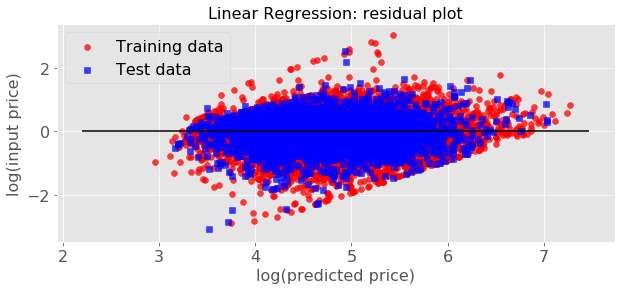

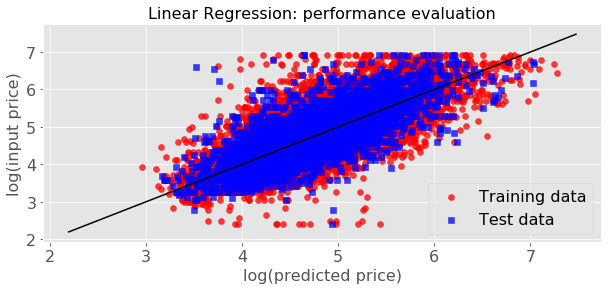

In [165]:
title0='Linear Regression:'
model_tmp = model_lr

title=title0 + ' training set model performance'
prediction_train=evaluate(model_tmp, X_train, y_train,title)

title=title0 + ' test set model performance'
prediction_test=evaluate(model_tmp, X_test, y_test,title)

#title=title0 + ' Charlie\'s'
#prediction_charlie=evaluate(model_tmp, X_charlie, y_charlie,title)
#print('Charlie\'s predicted price is {:0.4f}'.format(np.expm1(prediction_charlie[0])))
#print('Charlie\'s original price is {:0.4f}'.format(np.expm1(y_charlie.iloc[0])))

title=title0 + ' residual plot'
scatter_plot2(prediction_train,y_train,prediction_test,y_test,title)

title=title0 + ' performance evaluation'
scatter_plot3(prediction_train,y_train,prediction_test,y_test,title)

## 5(b) Lasso Regression 

In [119]:
# Lasso
lasso = Lasso(max_iter = 10000)
param_grid =dict(alpha=np.logspace(-4,1,50))
grid_lasso = GridSearchCV(lasso, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-)

grid_lasso.fit(X_train, y_train)

#print("grid.cv_results_ {}".format(grid_lr.cv_results_))
print("Linear Regression grid.best_score_: {}".format(grid_lasso.best_score_))
print("Linear Regression grid.best_params_: {}".format(grid_lasso.best_params_))
print("Linear Regression grid.best_estimator_: {}".format(grid_lasso.best_estimator_))


model_lasso = grid_lasso.best_estimator_


Linear Regression grid.best_score_: -0.15633314415808644
Linear Regression grid.best_params_: {'alpha': 0.0001}
Linear Regression grid.best_estimator_: Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


Lasso Regression: training set model performance
R^2: 0.6494
RMSE: $82.4340 
Average Error: $43.9024
Accuracy = 68.703%. 

Lasso Regression: test set model performance
R^2: 0.6441
RMSE: $79.1864 
Average Error: $43.4481
Accuracy = 68.620%. 



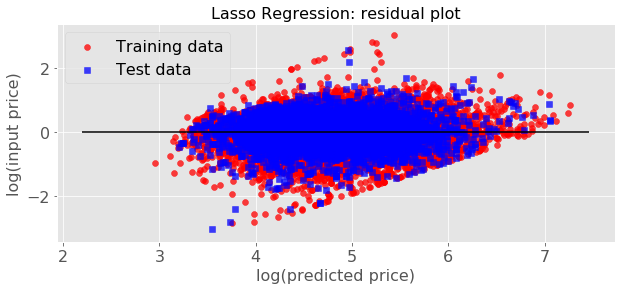

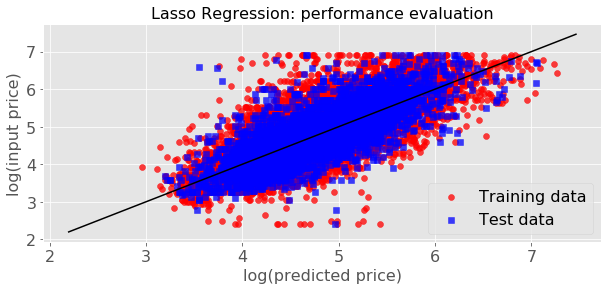

In [166]:
title0='Lasso Regression:'
model_tmp = model_lasso

title=title0 + ' training set model performance'
prediction_train=evaluate(model_tmp, X_train, y_train,title)

title=title0 + ' test set model performance'
prediction_test=evaluate(model_tmp, X_test, y_test,title)

#title=title0 + ' Charlie\'s rental'
#prediction_charlie=evaluate(model_tmp, X_charlie, y_charlie,title)
#print('Charlie\'s predicted price is {:0.4f}'.format(np.expm1(prediction_charlie[0])))
#print('Charlie\'s original price is {:0.4f}'.format(np.expm1(y_charlie.iloc[0])))

title=title0 + ' residual plot'
scatter_plot2(prediction_train,y_train,prediction_test,y_test,title)

title=title0 + ' performance evaluation'
scatter_plot3(prediction_train,y_train,prediction_test,y_test,title)

## 5(c) Hyperparameter-tuned Random forest regression 

In [121]:
rf= RandomForestRegressor(random_state=1, n_jobs=-2, max_features='log2')

param_grid = dict(n_estimators=[3000,4000,5000],
                  max_depth=[None, 4],
                  min_samples_leaf=[1,2])

grid_rf=GridSearchCV(rf, param_grid, cv=10, scoring='neg_mean_squared_error')

grid_rf.fit(X_train,y_train)

#print("Random forest grid.cv_results_ {}".format(grid_rf.cv_results_))
print("Random forest grid.best_score_ {}".format(grid_rf.best_score_))
print("Random forest grid.best_params_ {}".format(grid_rf.best_params_))
print("Random forest grid.best_estimator_ {}".format(grid_rf.best_estimator_))

model_rf = grid_rf.best_estimator_


Random forest grid.best_score_ -0.098971754918245
Random forest grid.best_params_ {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 5000}
Random forest grid.best_estimator_ RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='log2', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=5000,
                      n_jobs=-2, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)


Random Forest Regression: training set model performance
R^2: 0.9701
RMSE: $32.0300 
Average Error: $13.6510
Accuracy = 91.606%. 

Random Forest Regression: test set model performance
R^2: 0.7704
RMSE: $67.3586 
Average Error: $34.5259
Accuracy = 76.056%. 



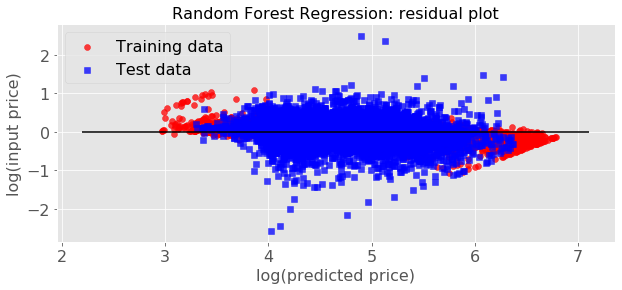

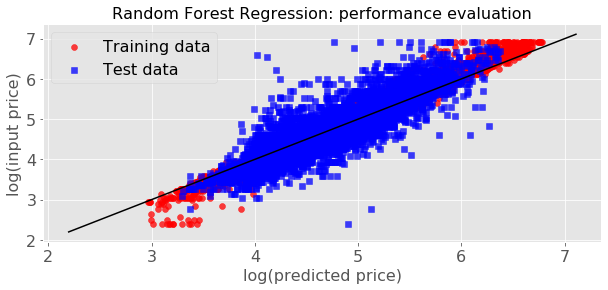

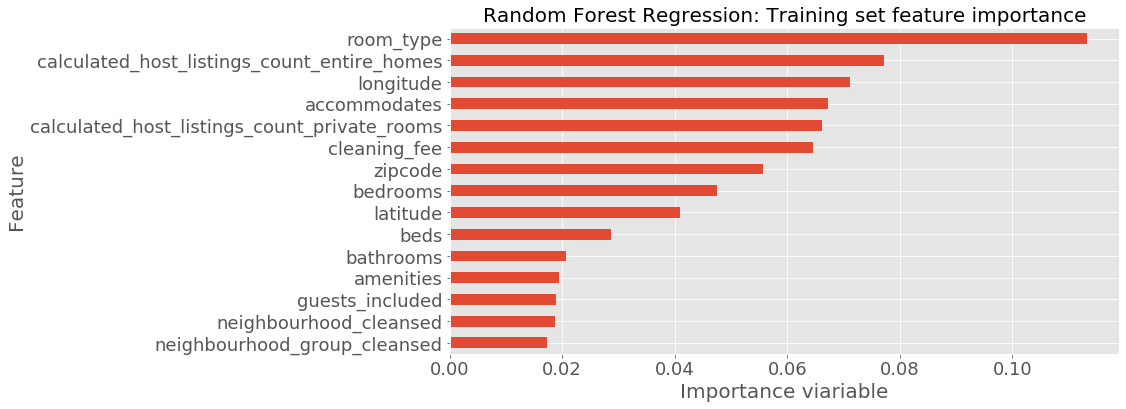

In [167]:
title0='Random Forest Regression:'
model_tmp = model_rf

title=title0 + ' training set model performance'
prediction_train=evaluate(model_tmp, X_train, y_train,title)

title=title0 + ' test set model performance'
prediction_test=evaluate(model_tmp, X_test, y_test,title)

#title=title0 + ' Charlie\'s rental'
#prediction_charlie=evaluate(model_tmp, X_charlie, y_charlie,title)
#print('Charlie\'s predicted price is {:0.4f}'.format(np.expm1(prediction_charlie[0])))
#print('Charlie\'s original price is {:0.4f}'.format(np.expm1(y_charlie.iloc[0])))

title=title0 + ' residual plot'
scatter_plot2(prediction_train,y_train,prediction_test,y_test,title)

title=title0 + ' performance evaluation'
scatter_plot3(prediction_train,y_train,prediction_test,y_test,title)

importances_train = pd.DataFrame({'Feature':X_train.columns, 'Importance':model_rf.feature_importances_})
importances_train = importances_train.sort_values('Importance',ascending=False).set_index('Feature')
feature_extraction(importances_train,'Random Forest Regression: Training set feature importance')

## 5(d) XGB model with hyperparameter tuning

**Hyperparameter tuning**

In [123]:
xgbr = xgb.XGBRegressor(random_state=1, n_jobs=-2,learning_rate=0.01)

param_grid = dict(gamma=[0.03,0.04], 
              max_depth=[4, 8, 12],
              n_estimators=[3000,4000])

#print(xgbr.get_params())

grid_xgbr=GridSearchCV(xgbr, param_grid, cv=10, scoring='neg_mean_squared_error')

grid_xgbr.fit(X_train,y_train)

#print("Random forest grid.cv_results_ {}".format(grid_rf.cv_results_))
print("XGB grid.best_score_ {}".format(grid_xgbr.best_score_))
print("XGB grid.best_params_ {}".format(grid_xgbr.best_params_))
print("XGB grid.best_estimator_ {}".format(grid_xgbr.best_estimator_))


model_xgbr = grid_xgbr.best_estimator_


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:08:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:09:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:09:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:10:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:10:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:11:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:11:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:12:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:12:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:13:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:13:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:14:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:14:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:15:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:16:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:16:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:17:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:17:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:18:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:18:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:19:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:20:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:21:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:22:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:23:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:24:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:25:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:26:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:27:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:28:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:29:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:31:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:32:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:34:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:35:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:36:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:38:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:40:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:41:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:42:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:44:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:45:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:47:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:49:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:50:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:52:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:53:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:55:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:57:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:59:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:00:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:03:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:05:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:07:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:09:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:11:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:13:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:14:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:16:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:18:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:20:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:21:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:21:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:23:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:23:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:23:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:24:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:24:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:25:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:25:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:27:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:27:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:28:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:28:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:29:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:29:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:30:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:33:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:34:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:35:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:36:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:37:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:38:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:53:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:54:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:56:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:57:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:59:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:00:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:02:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:04:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:05:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:07:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:09:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:10:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:12:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:14:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:16:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:18:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:20:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:22:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:26:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:28:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/attafynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:30:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB grid.best_score_ -0.09179586625622671
XGB grid.best_params_ {'gamma': 0.04, 'max_depth': 8, 'n_estimators': 4000}
XGB grid.best_estimator_ XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.04,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=4000,
             n_jobs=-2, nthread=None, objective='reg:linear', random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)


XGB Regression: training set model performance
R^2: 0.9317
RMSE: $34.6774 
Average Error: $18.7051
Accuracy = 86.910%. 

XGB Regression: test set model performance
R^2: 0.7846
RMSE: $61.7240 
Average Error: $33.1827
Accuracy = 76.646%. 



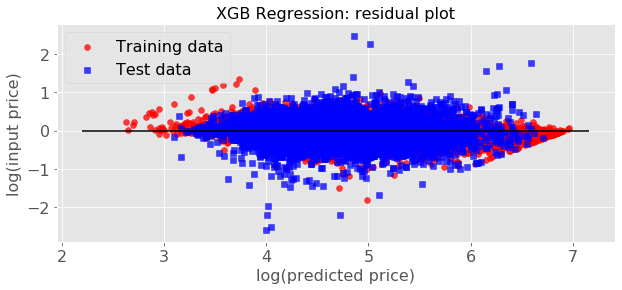

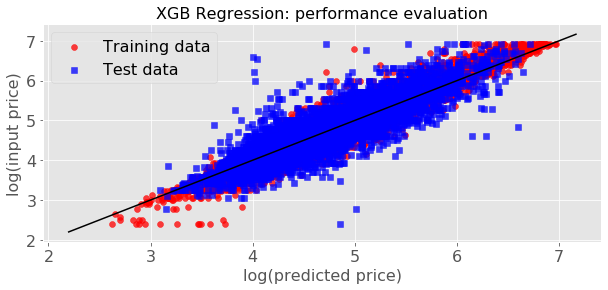

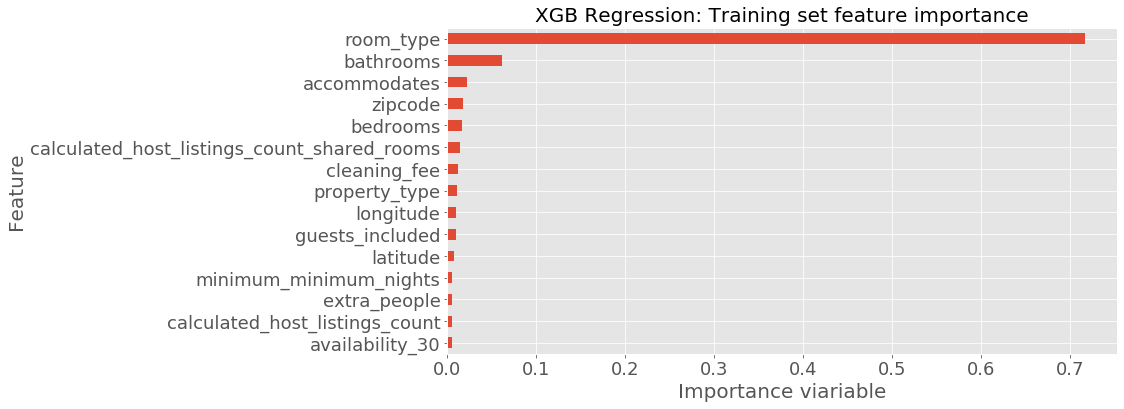

In [168]:
title0='XGB Regression:'
model_tmp = model_xgbr

title=title0 + ' training set model performance'
prediction_train=evaluate(model_tmp, X_train, y_train,title)

title=title0 + ' test set model performance'
prediction_test=evaluate(model_tmp, X_test, y_test,title)

#title=title0 + ' Charlie\'s rental'
#prediction_charlie=evaluate(model_tmp, X_charlie, y_charlie,title)
#print('Charlie\'s predicted price is {:0.4f}'.format(np.expm1(prediction_charlie[0])))
#print('Charlie\'s original price is {:0.4f}'.format(np.expm1(y_charlie.iloc[0])))

title=title0 + ' residual plot'
scatter_plot2(prediction_train,y_train,prediction_test,y_test,title)

title=title0 + ' performance evaluation'
scatter_plot3(prediction_train,y_train,prediction_test,y_test,title)

importances_train = pd.DataFrame({'Feature':X_train.columns, 'Importance':model_xgbr.feature_importances_})
importances_train = importances_train.sort_values('Importance',ascending=False).set_index('Feature')
feature_extraction(importances_train,'XGB Regression: Training set feature importance')

## 5(e) Hyperparameter tuned gradient boosting Regression

In [169]:
gbr = GradientBoostingRegressor(min_samples_split=400,
                                min_samples_leaf=50,
                                subsample=0.8,
                                random_state=1,
                               learning_rate=0.01,
                               max_features='sqrt')
#param_grid = {"n_estimators":np.arange(1000,10000,1000),'learning_rate':[0.01,0.05,0.1,0.25,0.5]}
param_grid = dict(n_estimators=[6000,7000], max_depth=[8,12,16])

grid_gbr=GridSearchCV(gbr, param_grid, cv=10, scoring='neg_mean_squared_error',n_jobs=-2)

grid_gbr.fit(X_train,y_train)

#print("Random forest grid.cv_results_ {}".format(grid_gbr.cv_results_))
print("Random forest grid.best_score_ {}".format(grid_gbr.best_score_))
print("Random forest grid.best_params_ {}".format(grid_gbr.best_params_))
print("Random forest grid.best_estimator_ {}".format(grid_gbr.best_estimator_))

model_gbr = grid_gbr.best_estimator_


Random forest grid.best_score_ -0.0903890981321449
Random forest grid.best_params_ {'max_depth': 12, 'n_estimators': 6000}
Random forest grid.best_estimator_ GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=12,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=50, min_samples_split=400,
                          min_weight_fraction_leaf=0.0, n_estimators=6000,
                          n_iter_no_change=None, presort='auto', random_state=1,
                          subsample=0.8, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)


Gradient Boosting Regression: training set model performance
R^2: 0.9224
RMSE: $39.9767 
Average Error: $20.1150
Accuracy = 86.181%. 

Gradient Boosting Regression: test set model performance
R^2: 0.7907
RMSE: $61.0986 
Average Error: $32.5379
Accuracy = 77.269%. 



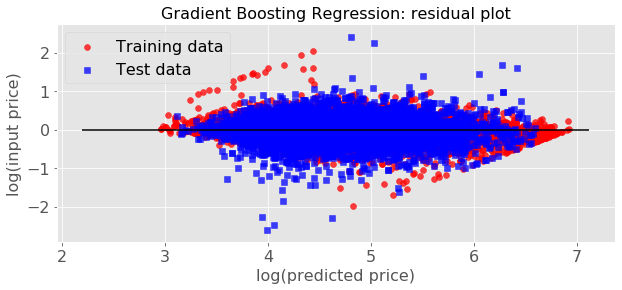

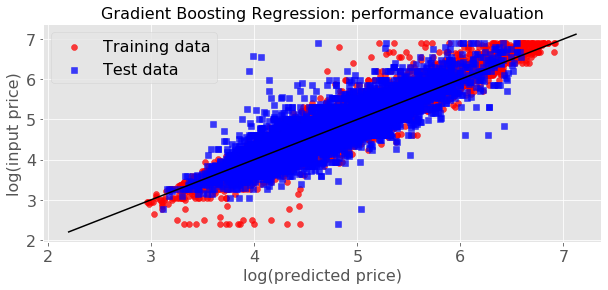

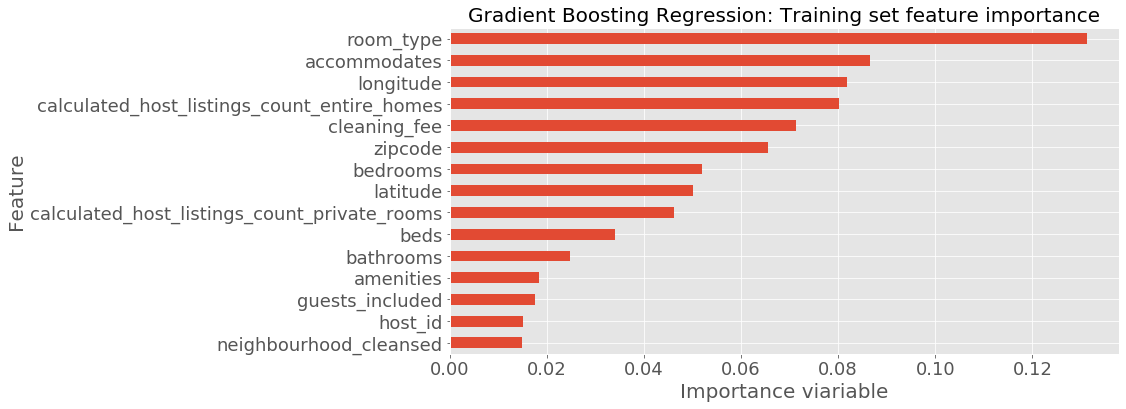

In [170]:
title0='Gradient Boosting Regression:'
model_tmp = model_gbr

title=title0 + ' training set model performance'
prediction_train=evaluate(model_tmp, X_train, y_train,title)

title=title0 + ' test set model performance'
prediction_test=evaluate(model_tmp, X_test, y_test,title)

title=title0 + ' residual plot'
scatter_plot2(prediction_train,y_train,prediction_test,y_test,title)

title=title0 + ' performance evaluation'
scatter_plot3(prediction_train,y_train,prediction_test,y_test,title)

importances_train = pd.DataFrame({'Feature':X_train.columns, 'Importance':model_tmp.feature_importances_})
importances_train = importances_train.sort_values('Importance',ascending=False).set_index('Feature')
feature_extraction(importances_train,'Gradient Boosting Regression: Training set feature importance')